
Configuration for BERAUSDT:


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


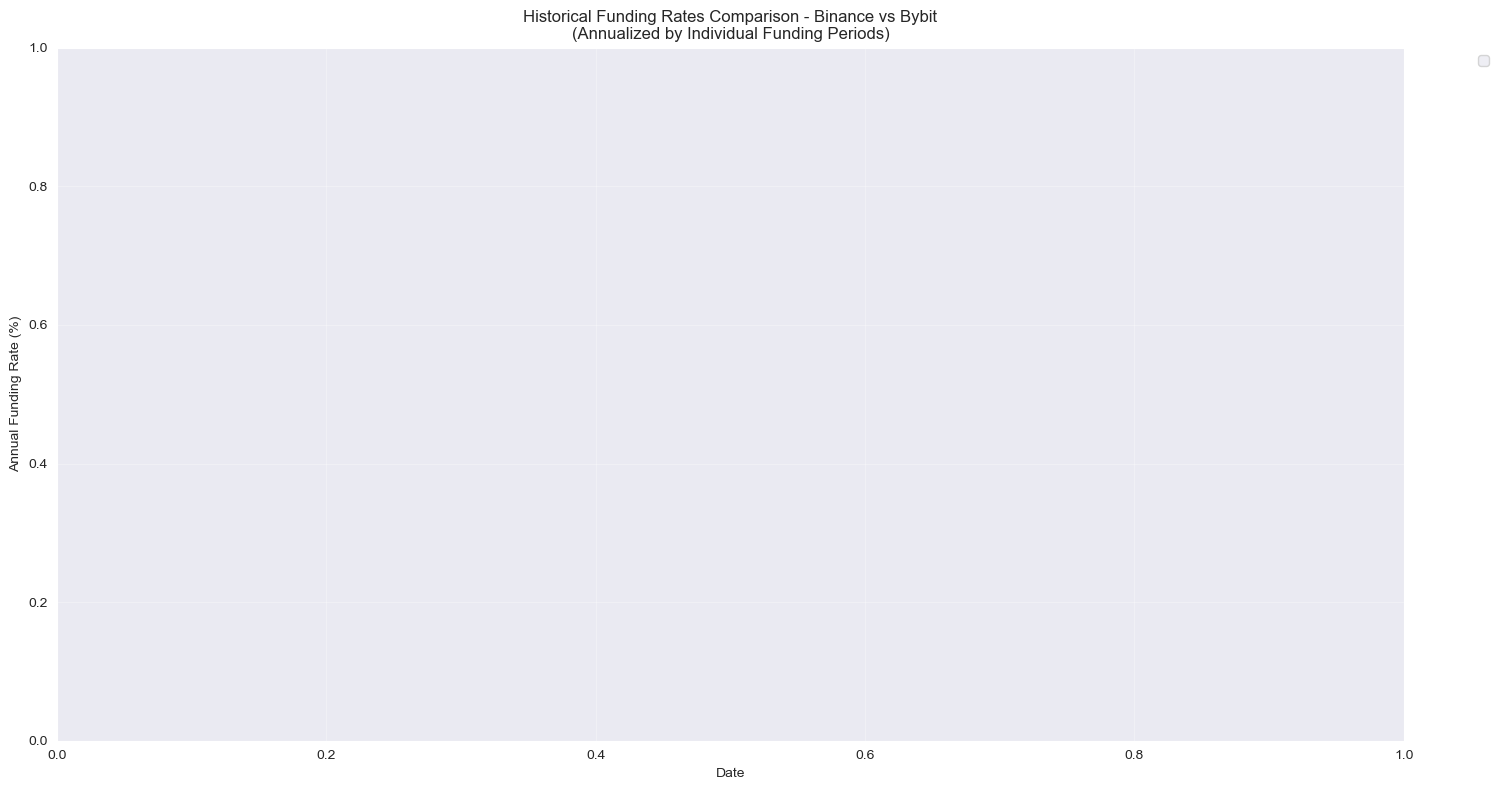


Summary Statistics (Annual Funding Rates %):
--------------------------------------------------

BERAUSDT:


In [1]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
from pybit.unified_trading import HTTP

# API URL for Binance funding rate
binance_funding_rate_url = "https://fapi.binance.com/fapi/v1/fundingRate"

def get_user_config():
    """Get user input for symbols and their configurations"""
    symbols = input("Enter symbols (comma-separated, e.g., TAOUSDT,SOLUSDT,ETHUSDT): ").strip().split(',')
    contract_type = input("Enter contract type (inverse/linear): ").strip().lower()
    
    symbols_config = {}
    for symbol in symbols:
        symbol = symbol.strip()
        print(f"\nConfiguration for {symbol}:")
        
        # Get Binance configuration
        binance_active = input(f"Include Binance for {symbol}? (y/n): ").strip().lower() == 'y'
        binance_period = None
        if binance_active:
            binance_period = int(input(f"Enter Binance funding period in hours for {symbol}: "))
        
        # Get Bybit configuration
        bybit_active = input(f"Include Bybit for {symbol}? (y/n): ").strip().lower() == 'y'
        bybit_period = None
        if bybit_active:
            bybit_period = int(input(f"Enter Bybit funding period in hours for {symbol}: "))
        
        symbols_config[symbol] = {
            "binance": {
                "active": binance_active,
                "funding_period": binance_period
            },
            "bybit": {
                "active": bybit_active,
                "funding_period": bybit_period
            }
        }
    
    return symbols_config, contract_type

# Get user configuration
symbols_config, contract_type = get_user_config()

# Define the start and end time in milliseconds
start_time = int(pd.Timestamp("2024-04-02").timestamp() * 1000)
end_time = int(pd.Timestamp("2025-04-02").timestamp() * 1000)

# Initialize the Bybit session using pybit
bybit_session = HTTP()

def fetch_binance_funding_rates(symbol, start_time):
    limit = 1000
    all_data = []
    
    while start_time < end_time:
        params = {
            "symbol": symbol,
            "limit": limit,
            "startTime": start_time
        }
        response = requests.get(binance_funding_rate_url, params=params)
        
        if response.status_code == 200:
            data = response.json()
            if not data:
                break

            all_data += [(item['fundingTime'], float(item['fundingRate'])) for item in data]
            start_time = data[-1]['fundingTime'] + 1
            time.sleep(1)
        else:
            print(f"Binance Error: {response.status_code}, {response.text}")
            break

    return all_data

def fetch_bybit_funding_rates(symbol, contract_type, start_time, end_time):
    all_data = []
    chunk_size_ms = 90 * 24 * 60 * 60 * 1000  # 90 days in milliseconds
    current_start = start_time

    while current_start < end_time:
        current_end = min(current_start + chunk_size_ms, end_time)
        try:
            response = bybit_session.get_funding_rate_history(
                category=contract_type,
                symbol=symbol,
                startTime=current_start,
                endTime=current_end
            )

            if 'result' in response and response['result'] and 'list' in response['result']:
                data = response['result']['list']
                if not data:
                    break
                all_data += [(int(item['fundingRateTimestamp']), float(item['fundingRate'])) for item in data]

                # Advance to the next chunk using the last timestamp returned
                last_timestamp = max(int(item['fundingRateTimestamp']) for item in data)
                current_start = last_timestamp + 1
                time.sleep(1)  # Be nice to the API
            else:
                print(f"Bybit Error or no more data: {response}")
                break
        except Exception as e:
            print(f"Error fetching Bybit data for {symbol}: {e}")
            break

    return all_data

def calculate_annual_funding_rate(funding_rate, funding_period):
    """Calculate annualized funding rate based on funding period"""
    periods_per_year = (24 * 365) / funding_period
    return funding_rate * periods_per_year * 100

# Color mapping for different symbols and exchanges
color_map = {
    'TAOUSDT': {'binance': '#FF9999', 'bybit': '#FF3333'},
    'SOLUSDT': {'binance': '#99FF99', 'bybit': '#33FF33'},
    'ETHUSDT': {'binance': '#9999FF', 'bybit': '#3333FF'},
    # Add more symbols with their colors as needed
}

# Default colors for new symbols
default_colors = [
    {'binance': '#FFB366', 'bybit': '#FF8000'},  # Orange
    {'binance': '#FF99FF', 'bybit': '#FF33FF'},  # Pink
    {'binance': '#99FFFF', 'bybit': '#33FFFF'},  # Cyan
]

# Assign colors to symbols not in color_map
for i, symbol in enumerate([s for s in symbols_config if s not in color_map]):
    color_map[symbol] = default_colors[i % len(default_colors)]

# Fetch and store funding rate data
binance_funding_data = {}
bybit_funding_data = {}

# Fetch data from both exchanges based on configuration
for symbol, config in symbols_config.items():
    if config['binance']['active']:
        print(f"Fetching historical funding rates for {symbol} on Binance...")
        binance_data = fetch_binance_funding_rates(symbol, start_time)
        df_binance = pd.DataFrame(binance_data, columns=['Funding Time', 'Funding Rate'])
        df_binance['Funding Time'] = pd.to_datetime(df_binance['Funding Time'], unit='ms')
        df_binance.set_index("Funding Time", inplace=True)
        binance_funding_data[symbol] = df_binance

    if config['bybit']['active']:
        print(f"Fetching historical funding rates for {symbol} on Bybit...")
        bybit_data = fetch_bybit_funding_rates(symbol, contract_type, start_time, end_time)
        df_bybit = pd.DataFrame(bybit_data, columns=['Funding Time', 'Funding Rate'])
        df_bybit['Funding Time'] = pd.to_datetime(df_bybit['Funding Time'], unit='ms')
        df_bybit.set_index("Funding Time", inplace=True)
        bybit_funding_data[symbol] = df_bybit

# Create the plot
plt.figure(figsize=(15, 8))

# Plot data for each symbol based on configuration
for symbol, config in symbols_config.items():
    if config['binance']['active']:
        funding_period = config['binance']['funding_period']
        df_binance = binance_funding_data[symbol]
        annual_rate = calculate_annual_funding_rate(df_binance['Funding Rate'], funding_period)
        plt.plot(df_binance.index, 
                 annual_rate,
                 label=f'Binance {symbol} ({funding_period}h)',
                 color=color_map[symbol]['binance'],
                 linewidth=1)

    if config['bybit']['active']:
        funding_period = config['bybit']['funding_period']
        df_bybit = bybit_funding_data[symbol]
        annual_rate = calculate_annual_funding_rate(df_bybit['Funding Rate'], funding_period)
        plt.plot(df_bybit.index,
                 annual_rate,
                 label=f'Bybit {symbol} ({funding_period}h)',
                 color=color_map[symbol]['bybit'],
                 linewidth=1)

# Customize the plot
plt.title('Historical Funding Rates Comparison - Binance vs Bybit\n(Annualized by Individual Funding Periods)')
plt.xlabel('Date')
plt.ylabel('Annual Funding Rate (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Display the plot
plt.show()

# Print summary statistics
print("\nSummary Statistics (Annual Funding Rates %):")
print("-" * 50)
for symbol, config in symbols_config.items():
    print(f"\n{symbol}:")
    
    if config['binance']['active']:
        funding_period = config['binance']['funding_period']
        annual_rate = calculate_annual_funding_rate(
            binance_funding_data[symbol]['Funding Rate'], 
            funding_period
        )
        binance_stats = annual_rate.describe()
        print(f"Binance ({funding_period}h) - "
              f"Mean: {binance_stats['mean']:.2f}%, "
              f"Std: {binance_stats['std']:.2f}%, "
              f"Min: {binance_stats['min']:.2f}%, "
              f"Max: {binance_stats['max']:.2f}%,"
              f"Median: {binance_stats['50%']:.2f}%")
    
    if config['bybit']['active']:
        funding_period = config['bybit']['funding_period']
        annual_rate = calculate_annual_funding_rate(
            bybit_funding_data[symbol]['Funding Rate'], 
            funding_period
        )
        bybit_stats = annual_rate.describe()
        print(f"Bybit ({funding_period}h)   - "
              
              f"Mean: {bybit_stats['mean']:.2f}%, "
              f"Std: {bybit_stats['std']:.2f}%, "
              f"Min: {bybit_stats['min']:.2f}%, "
              f"Max: {bybit_stats['max']:.2f}%,"
              f"Median: {bybit_stats['50%']:.2f}%"
              )

Fetching 4h data for BERAUSDT...
Combined DataFrame (first 5 rows):
                     BERAUSDT
Open Time                    
2025-02-06 12:00:00     8.883
2025-02-06 16:00:00     7.800
2025-02-06 20:00:00     8.717
2025-02-07 00:00:00     8.181
2025-02-07 04:00:00     7.572
Combined DataFrame (last 5 rows):
                     BERAUSDT
Open Time                    
2025-04-14 16:00:00     4.030
2025-04-14 20:00:00     3.999
2025-04-15 00:00:00     4.114
2025-04-15 04:00:00     4.147
2025-04-15 08:00:00     4.115
Annualized Volatility for BERAUSDT: 161.59%


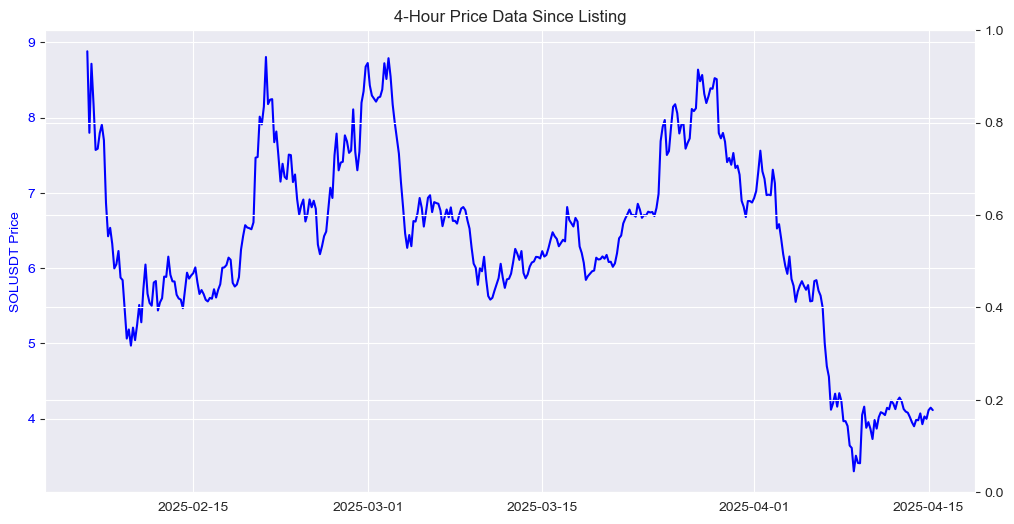

In [4]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_all_binance_4h_data(symbol, start_str=None, end_str=None):
    """
    Fetches historical 4-hour price data for a given symbol from Binance,
    looping over all available data (or between start_str and end_str).

    Parameters:
      symbol: Trading pair symbol (e.g. "BTCUSDT").
      start_str: (Optional) Start date in format "YYYY-MM-DD".
      end_str:   (Optional) End date in format "YYYY-MM-DD".
      
    Returns:
      A pandas DataFrame with columns "Open Time" and "Close".
    """
    url = "https://api.binance.com/api/v3/klines"
    limit = 1000  # Maximum per request
    df = pd.DataFrame()

    if start_str:
        startTime = int(pd.Timestamp(start_str).timestamp() * 1000)
    else:
        startTime = None
    if end_str:
        endTime = int(pd.Timestamp(end_str).timestamp() * 1000)
    else:
        endTime = None

    while True:
        params = {
            "symbol": symbol.upper(),
            "interval": "4h",
            "limit": limit
        }
        if startTime is not None:
            params["startTime"] = startTime
        if endTime is not None:
            params["endTime"] = endTime

        response = requests.get(url, params=params)
        if response.status_code != 200:
            print(f"Error: {response.status_code}, {response.text}")
            break

        data = response.json()
        if not data:
            break

        temp_df = pd.DataFrame(data, columns=[
            "Open Time", "Open", "High", "Low", "Close", "Volume",
            "Close Time", "Quote Asset Volume", "Number of Trades",
            "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore"
        ])
        df = pd.concat([df, temp_df], ignore_index=True)
        startTime = int(data[-1][0]) + 1

        if len(data) < limit:
            break

    df["Open Time"] = pd.to_datetime(df["Open Time"], unit="ms")
    df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
    return df[["Open Time", "Close"]]

def calculate_annualized_volatility(df):
    """
    Computes the annualized volatility from a DataFrame that has one column of closing prices.
    """
    df = df.copy()
    # Use the first column in the DataFrame as the close prices.
    price_col = df.columns[1] if 'Open Time' in df.columns else df.columns[0]
    df["Log Returns"] = np.log(df[price_col] / df[price_col].shift(1))
    df.dropna(inplace=True)
    sigma_4h = df["Log Returns"].std()
    periods_per_year = (24 / 4) * 365  # Approximately 2190 periods per year.
    annualized_volatility = sigma_4h * np.sqrt(periods_per_year)
    return annualized_volatility

# ----- Example Usage: Fetch and Plot Data for Multiple Symbols -----
symbols = ["BERAUSDT"]
data_dict = {}

# Fetch data for each symbol
for symbol in symbols:
    print(f"Fetching 4h data for {symbol}...")
    df = get_all_binance_4h_data(symbol, start_str="2020-01-01")
    if df is not None and not df.empty:
        # Set "Open Time" as the index.
        df.set_index("Open Time", inplace=True)
        data_dict[symbol] = df
    else:
        print(f"No data for {symbol}")

# Save JUPUSDT data into CSV
if "JUPUSDT" in data_dict:
    data_dict["JUPUSDT"].to_csv("JUPUSDT_4h.csv")
    print("JUPUSDT 4h data saved to JUPUSDT_4h.csv")

# Combine the data into one DataFrame. We'll join on the datetime index.
combined_df = pd.concat([data_dict[sym]["Close"].rename(sym) for sym in symbols], axis=1, join="outer")
combined_df.sort_index(inplace=True)

print("Combined DataFrame (first 5 rows):")
print(combined_df.head())
print("Combined DataFrame (last 5 rows):")
print(combined_df.tail())

# Calculate annualized volatility for each symbol
for sym in symbols:
    # Re-create a DataFrame with a "Close" column for the symbol.
    df_sym = combined_df[[sym]].dropna()
    vol = calculate_annualized_volatility(df_sym.reset_index())
    print(f"Annualized Volatility for {sym}: {vol:.2%}")

plt.figure(figsize=(12,6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot SOL data on left y-axis
ax1.plot(combined_df.index, combined_df["BERAUSDT"], label="SOLUSDT", color="blue")
ax1.set_ylabel("SOLUSDT Price", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")


plt.xlabel("Time")
plt.title("4-Hour Price Data Since Listing")
plt.grid(True)
plt.show()


Fetching 4h data for TONUSDT...
Combined DataFrame (first 5 rows):
                     TONUSDT
Open Time                   
2024-08-08 08:00:00    6.169
2024-08-08 12:00:00    6.276
2024-08-08 16:00:00    6.143
2024-08-08 20:00:00    6.218
2024-08-09 00:00:00    6.196
Combined DataFrame (last 5 rows):
                     TONUSDT
Open Time                   
2025-03-31 16:00:00    4.096
2025-03-31 20:00:00    4.109
2025-04-01 00:00:00    4.135
2025-04-01 04:00:00    4.106
2025-04-01 08:00:00    4.103
Annualized Volatility for TONUSDT: 81.72%


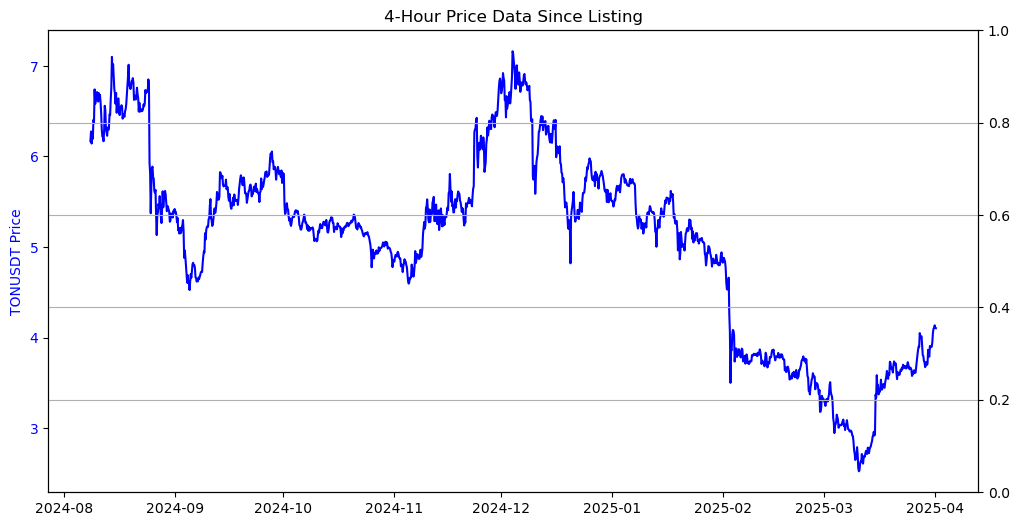

In [4]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_all_binance_4h_data(symbol, start_str=None, end_str=None):
    """
    Fetches historical 4-hour price data for a given symbol from Binance,
    looping over all available data (or between start_str and end_str).

    Parameters:
      symbol: Trading pair symbol (e.g. "BTCUSDT").
      start_str: (Optional) Start date in format "YYYY-MM-DD".
      end_str:   (Optional) End date in format "YYYY-MM-DD".
      
    Returns:
      A pandas DataFrame with columns "Open Time" and "Close".
    """
    url = "https://api.binance.com/api/v3/klines"
    limit = 1000  # Maximum per request
    df = pd.DataFrame()

    if start_str:
        startTime = int(pd.Timestamp(start_str).timestamp() * 1000)
    else:
        startTime = None
    if end_str:
        endTime = int(pd.Timestamp(end_str).timestamp() * 1000)
    else:
        endTime = None

    while True:
        params = {
            "symbol": symbol.upper(),
            "interval": "4h",
            "limit": limit
        }
        if startTime is not None:
            params["startTime"] = startTime
        if endTime is not None:
            params["endTime"] = endTime

        response = requests.get(url, params=params)
        if response.status_code != 200:
            print(f"Error: {response.status_code}, {response.text}")
            break

        data = response.json()
        if not data:
            break

        temp_df = pd.DataFrame(data, columns=[
            "Open Time", "Open", "High", "Low", "Close", "Volume",
            "Close Time", "Quote Asset Volume", "Number of Trades",
            "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore"
        ])
        df = pd.concat([df, temp_df], ignore_index=True)
        startTime = int(data[-1][0]) + 1

        if len(data) < limit:
            break

    df["Open Time"] = pd.to_datetime(df["Open Time"], unit="ms")
    df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
    return df[["Open Time", "Close"]]

def calculate_annualized_volatility(df):
    """
    Computes the annualized volatility from a DataFrame that has one column of closing prices.
    """
    df = df.copy()
    # Use the first column in the DataFrame as the close prices.
    price_col = df.columns[1] if 'Open Time' in df.columns else df.columns[0]
    df["Log Returns"] = np.log(df[price_col] / df[price_col].shift(1))
    df.dropna(inplace=True)
    sigma_4h = df["Log Returns"].std()
    periods_per_year = (24 / 4) * 365  # Approximately 2190 periods per year.
    annualized_volatility = sigma_4h * np.sqrt(periods_per_year)
    return annualized_volatility


# ----- Example Usage: Fetch and Plot Data for Multiple Symbols -----
symbols = ["TONUSDT"]
data_dict = {}

# Fetch data for each symbol
for symbol in symbols:
    print(f"Fetching 4h data for {symbol}...")
    df = get_all_binance_4h_data(symbol, start_str="2020-01-01")
    if df is not None and not df.empty:
        # Set "Open Time" as the index.
        df.set_index("Open Time", inplace=True)
        data_dict[symbol] = df
    else:
        print(f"No data for {symbol}")

# Combine the data into one DataFrame. We'll join on the datetime index.
combined_df = pd.concat([data_dict[sym]["Close"].rename(sym) for sym in symbols], axis=1, join="outer")
combined_df.sort_index(inplace=True)

print("Combined DataFrame (first 5 rows):")
print(combined_df.head())
print("Combined DataFrame (last 5 rows):")
print(combined_df.tail())

# Calculate annualized volatility for each symbol
for sym in symbols:
    # Re-create a DataFrame with a "Close" column for the symbol.
    df_sym = combined_df[[sym]].dropna()
    vol = calculate_annualized_volatility(df_sym.reset_index())
    print(f"Annualized Volatility for {sym}: {vol:.2%}")

plt.figure(figsize=(12,6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot SOL data on left y-axis
ax1.plot(combined_df.index, combined_df["TONUSDT"], label="TONUSDT", color="blue")
ax1.set_ylabel("TONUSDT Price", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")


plt.xlabel("Time")
plt.title("4-Hour Price Data Since Listing")
plt.grid(True)
plt.show()


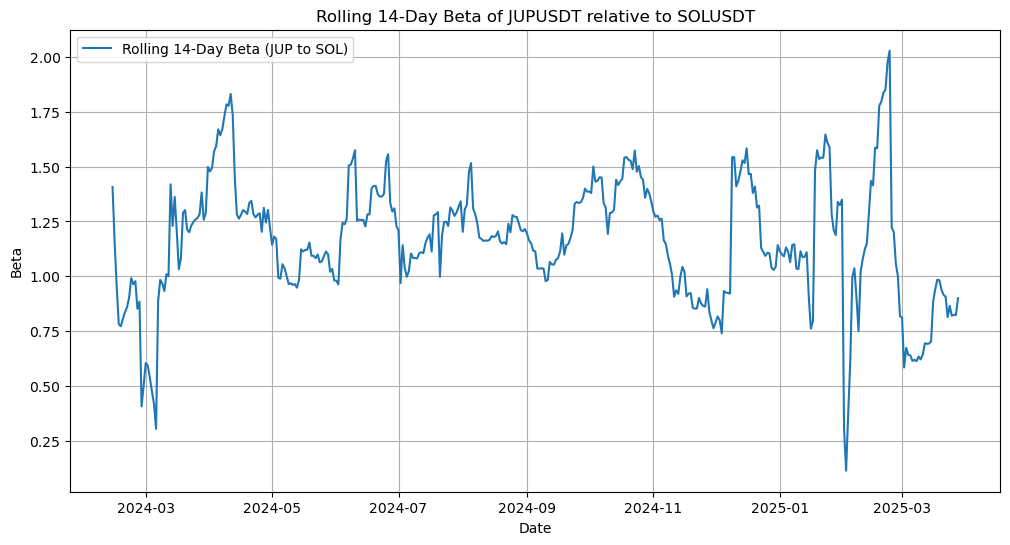

Rolling 14-Day Beta (first 5 rows):
Open Time
2024-02-14    1.407246
2024-02-15    1.155483
2024-02-16    0.954307
2024-02-17    0.781262
2024-02-18    0.771774
Freq: D, dtype: float64


In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume combined_df is your DataFrame with columns "JUPUSDT" and "SOLUSDT" indexed by datetime.

# 1. Resample to daily data. We use the 'last' price of the day.
daily_prices = combined_df.resample("D").last()

# 2. Compute daily percentage returns.
daily_returns = daily_prices.pct_change()

# 3. Define the rolling window (14 days).
window = 14

# 4. Compute rolling beta:
# Beta = Cov(JUP returns, SOL returns) / Var(SOL returns)
rolling_beta = daily_returns["JUPUSDT"].rolling(window).cov(daily_returns["SOLUSDT"]) / daily_returns["SOLUSDT"].rolling(window).var()

# 5. Plot the rolling beta.
plt.figure(figsize=(12,6))
plt.plot(rolling_beta.index, rolling_beta, label="Rolling 14-Day Beta (JUP to SOL)")
plt.xlabel("Date")
plt.ylabel("Beta")
plt.title("Rolling 14-Day Beta of JUPUSDT relative to SOLUSDT")
plt.legend()
plt.grid(True)
plt.show()

# 6. Optional: Print out a sample of the rolling beta values.
print("Rolling 14-Day Beta (first 5 rows):")
print(rolling_beta.dropna().head())



Configuration for BERAUSDT:


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


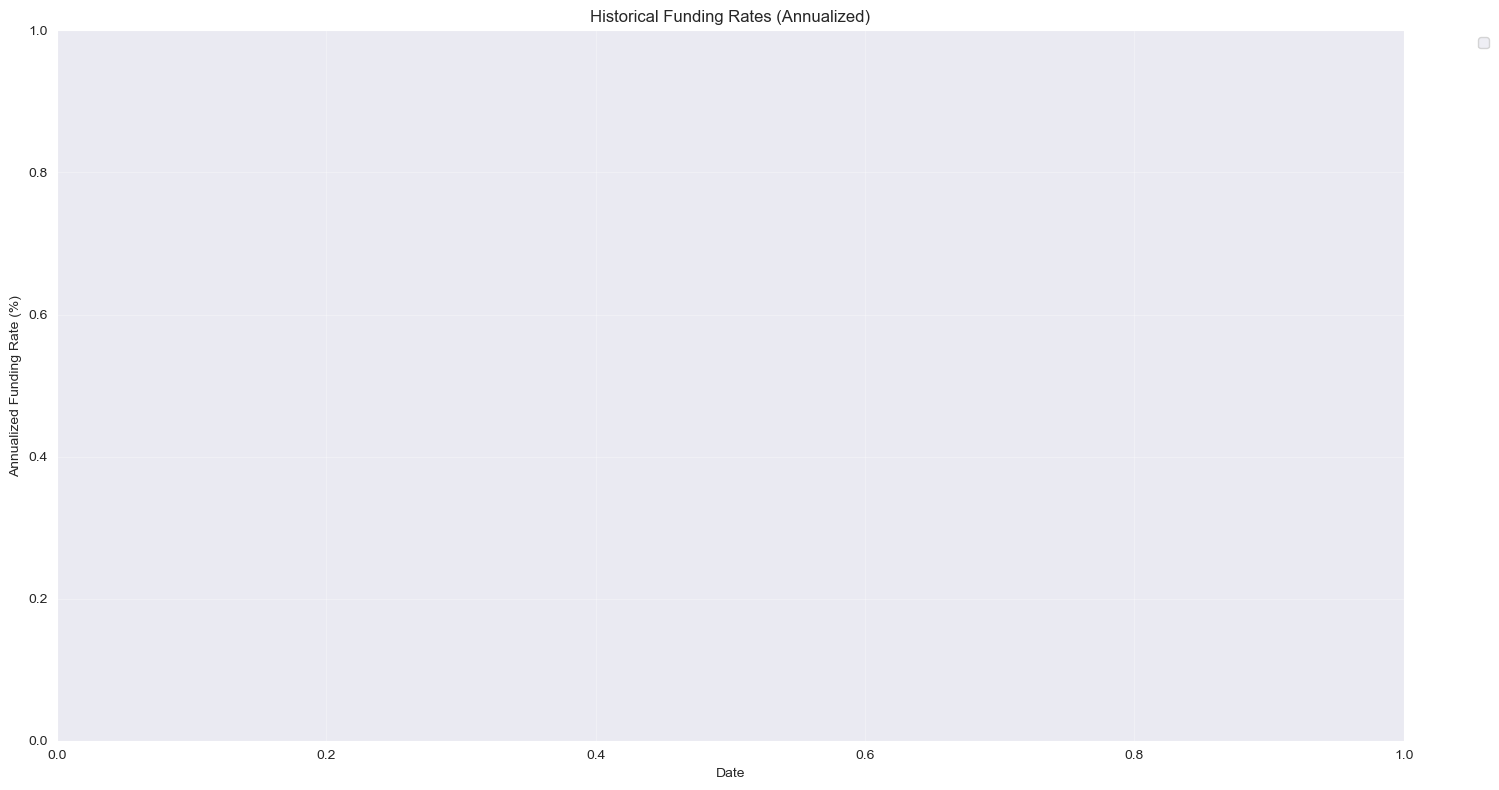

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Summary Statistics (Annualized Funding Rate %)
------------------------------------------------------------

BERAUSDT:


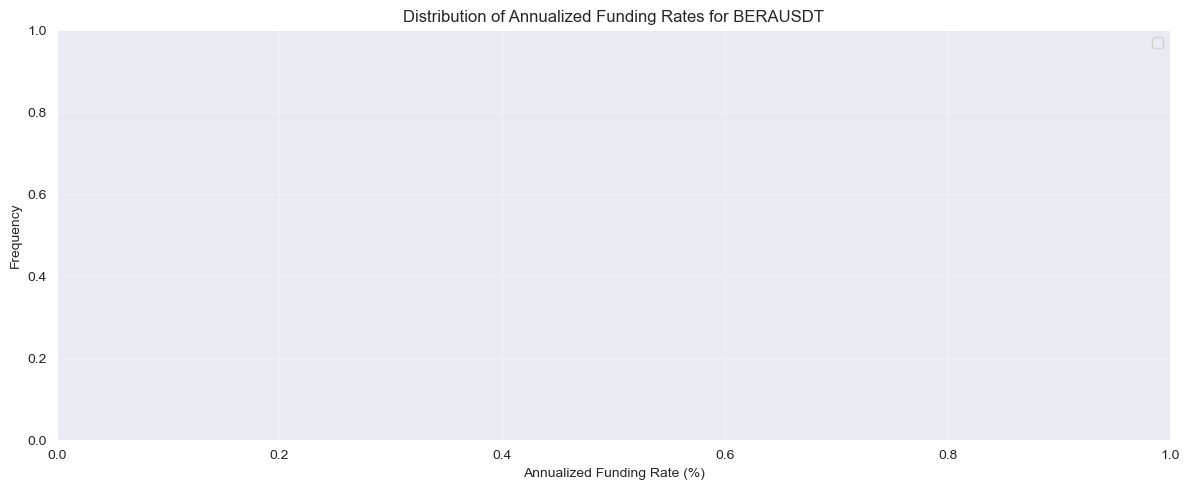

In [6]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
from pybit.unified_trading import HTTP

# -----------------------------
# User Configuration Functions
# -----------------------------

def get_user_config():
    """Prompt user for symbols and exchange-specific config"""
    symbols = input("Enter symbols (comma-separated, e.g., TAOUSDT,SOLUSDT,ETHUSDT): ").strip().split(',')
    contract_type = input("Enter contract type (inverse/linear): ").strip().lower()
    
    symbols_config = {}
    for symbol in symbols:
        symbol = symbol.strip().upper()
        print(f"\nConfiguration for {symbol}:")
        
        binance_active = input(f"Include Binance for {symbol}? (y/n): ").strip().lower() == 'y'
        binance_period = int(input(f"Enter Binance funding period in hours for {symbol}: ")) if binance_active else None
        
        bybit_active = input(f"Include Bybit for {symbol}? (y/n): ").strip().lower() == 'y'
        bybit_period = int(input(f"Enter Bybit funding period in hours for {symbol}: ")) if bybit_active else None
        
        symbols_config[symbol] = {
            "binance": {"active": binance_active, "funding_period": binance_period},
            "bybit": {"active": bybit_active, "funding_period": bybit_period}
        }

    return symbols_config, contract_type


# -----------------------------
# Binance Data Fetching
# -----------------------------

def fetch_binance_funding_rates(symbol, start_time, end_time):
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    limit = 1000
    all_data = []

    while start_time < end_time:
        params = {
            "symbol": symbol,
            "limit": limit,
            "startTime": start_time
        }
        response = requests.get(url, params=params)

        if response.status_code == 200:
            data = response.json()
            if not data:
                break
            all_data += [(int(item['fundingTime']), float(item['fundingRate'])) for item in data]
            start_time = int(data[-1]['fundingTime']) + 1
            time.sleep(1)
        else:
            print(f"Binance Error: {response.status_code}, {response.text}")
            break

    return all_data


# -----------------------------
# Bybit Listing Time Helper
# -----------------------------

def get_bybit_listing_time(symbol, contract_type):
    """Fetch the listing (launch) time of a Bybit symbol"""
    url = "https://api.bybit.com/v5/market/instruments-info"
    res = requests.get(url, params={"category": contract_type})
    data = res.json()
    if 'result' in data and 'list' in data['result']:
        for item in data['result']['list']:
            if item['symbol'] == symbol:
                return int(item['launchTime'])  # In milliseconds
    raise ValueError(f"Launch time not found for symbol {symbol} in {contract_type}")


# -----------------------------
# Bybit Data Fetching with Listing Time
# -----------------------------

def fetch_bybit_funding_rates(symbol, contract_type, end_time):
    session = HTTP()
    try:
        launch_time = get_bybit_listing_time(symbol, contract_type)
        print(f"Bybit listing time for {symbol}: {pd.to_datetime(launch_time, unit='ms')}")
    except ValueError as e:
        print(f"❌ {e}")
        return []  # Gracefully skip fetching if symbol not found
    chunk_size_ms = 90 * 24 * 60 * 60 * 1000  # 90 days
    current_start = launch_time
    all_data = []

    while current_start < end_time:
        current_end = min(current_start + chunk_size_ms, end_time)

        try:
            response = session.get_funding_rate_history(
                category=contract_type,
                symbol=symbol,
                startTime=current_start,
                endTime=current_end
            )

            if 'result' in response and response['result'] and 'list' in response['result']:
                data = response['result']['list']
                if not data:
                    print("No data in chunk. Skipping ahead.")
                    current_start = current_end + 1
                    continue
                all_data += [(int(item['fundingRateTimestamp']), float(item['fundingRate'])) for item in data]
                last_timestamp = max(int(item['fundingRateTimestamp']) for item in data)
                current_start = last_timestamp + 1
                time.sleep(1)
            else:
                print(f"No data returned or malformed response: {response}")
                current_start = current_end + 1
        except Exception as e:
            print(f"Bybit fetch error for {symbol}: {e}")
            current_start = current_end + 1

    return all_data


# -----------------------------
# Annualization Function
# -----------------------------

def calculate_annual_funding_rate(funding_rate_series, funding_period_hours):
    periods_per_year = (24 * 365) / funding_period_hours
    return funding_rate_series * periods_per_year * 100


# -----------------------------
# Plotting & Summary
# -----------------------------

def plot_funding_rates(symbols_config, binance_data, bybit_data, color_map):
    plt.figure(figsize=(15, 8))

    for symbol, config in symbols_config.items():
        if config['binance']['active'] and symbol in binance_data:
            df = binance_data[symbol]
            annual_rate = calculate_annual_funding_rate(df['Funding Rate'], config['binance']['funding_period'])
            plt.plot(df.index, annual_rate, label=f'Binance {symbol}', color=color_map[symbol]['binance'])

        if config['bybit']['active'] and symbol in bybit_data:
            df = bybit_data[symbol]
            annual_rate = calculate_annual_funding_rate(df['Funding Rate'], config['bybit']['funding_period'])
            plt.plot(df.index, annual_rate, label=f'Bybit {symbol}', color=color_map[symbol]['bybit'])

    plt.title('Historical Funding Rates (Annualized)')
    plt.xlabel('Date')
    plt.ylabel('Annualized Funding Rate (%)')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def print_summary(symbols_config, binance_data, bybit_data):
    print("\nSummary Statistics (Annualized Funding Rate %)")
    print("-" * 60)
    for symbol, config in symbols_config.items():
        print(f"\n{symbol}:")
        if config['binance']['active'] and symbol in binance_data:
            series = calculate_annual_funding_rate(binance_data[symbol]['Funding Rate'], config['binance']['funding_period'])
            if not series.empty:
                stats = series.describe()
                print(f"  Binance: Mean={stats['mean']:.2f}%, Std={stats['std']:.2f}%, Min={stats['min']:.2f}%, Max={stats['max']:.2f}%, Median={stats['50%']:.2f}%")
            else:
                print("  Binance: No data.")

        if config['bybit']['active'] and symbol in bybit_data:
            series = calculate_annual_funding_rate(bybit_data[symbol]['Funding Rate'], config['bybit']['funding_period'])
            if not series.empty:
                stats = series.describe()
                print(f"  Bybit:   Mean={stats['mean']:.2f}%, Std={stats['std']:.2f}%, Min={stats['min']:.2f}%, Max={stats['max']:.2f}%, Median={stats['50%']:.2f}%")
            else:
                print("  Bybit:   No data.")

def plot_histograms(symbols_config, binance_data, bybit_data):
    for symbol, config in symbols_config.items():
        plt.figure(figsize=(12, 5))
        plt.title(f"Distribution of Annualized Funding Rates for {symbol}")

        if config['binance']['active'] and symbol in binance_data:
            series = calculate_annual_funding_rate(
                binance_data[symbol]['Funding Rate'], config['binance']['funding_period']
            )
            plt.hist(series, bins=50, alpha=0.6, label='Binance', color='skyblue', edgecolor='black')

        if config['bybit']['active'] and symbol in bybit_data:
            series = calculate_annual_funding_rate(
                bybit_data[symbol]['Funding Rate'], config['bybit']['funding_period']
            )
            plt.hist(series, bins=50, alpha=0.6, label='Bybit', color='salmon', edgecolor='black')

        plt.xlabel("Annualized Funding Rate (%)")
        plt.ylabel("Frequency")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# -----------------------------
# Main Execution
# -----------------------------

if __name__ == "__main__":
    # Set end time (today); start time for Binance is fixed
    start_time = int(pd.Timestamp("2025-03-01").timestamp() * 1000)
    end_time = int(pd.Timestamp("2025-04-01").timestamp() * 1000)

    # Get config
    symbols_config, contract_type = get_user_config()

    # Setup colors
    default_colors = [
        {'binance': '#FFB366', 'bybit': '#FF8000'},
        {'binance': '#FF99FF', 'bybit': '#FF33FF'},
        {'binance': '#99FFFF', 'bybit': '#33FFFF'},
    ]
    color_map = {
        'TAOUSDT': {'binance': '#FF9999', 'bybit': '#FF3333'},
        'SOLUSDT': {'binance': '#99FF99', 'bybit': '#33FF33'},
        'ETHUSDT': {'binance': '#9999FF', 'bybit': '#3333FF'},
    }
    for i, sym in enumerate([s for s in symbols_config if s not in color_map]):
        color_map[sym] = default_colors[i % len(default_colors)]

    # Fetch data
    binance_data = {}
    bybit_data = {}

    for symbol, config in symbols_config.items():
        if config['binance']['active']:
            print(f"\nFetching Binance data for {symbol}...")
            data = fetch_binance_funding_rates(symbol, start_time, end_time)
            if data:
                df = pd.DataFrame(data, columns=["Funding Time", "Funding Rate"])
                df["Funding Time"] = pd.to_datetime(df["Funding Time"], unit='ms')
                df.set_index("Funding Time", inplace=True)
                binance_data[symbol] = df

        if config['bybit']['active']:
            print(f"\nFetching Bybit data for {symbol}...")
            data = fetch_bybit_funding_rates(symbol, contract_type, end_time)
            if data:
                df = pd.DataFrame(data, columns=["Funding Time", "Funding Rate"])
                df["Funding Time"] = pd.to_datetime(df["Funding Time"], unit='ms')
                df.set_index("Funding Time", inplace=True)
                bybit_data[symbol] = df

    # Plot and print
    plot_funding_rates(symbols_config, binance_data, bybit_data, color_map)
    print_summary(symbols_config, binance_data, bybit_data)
    plot_histograms(symbols_config, binance_data, bybit_data)


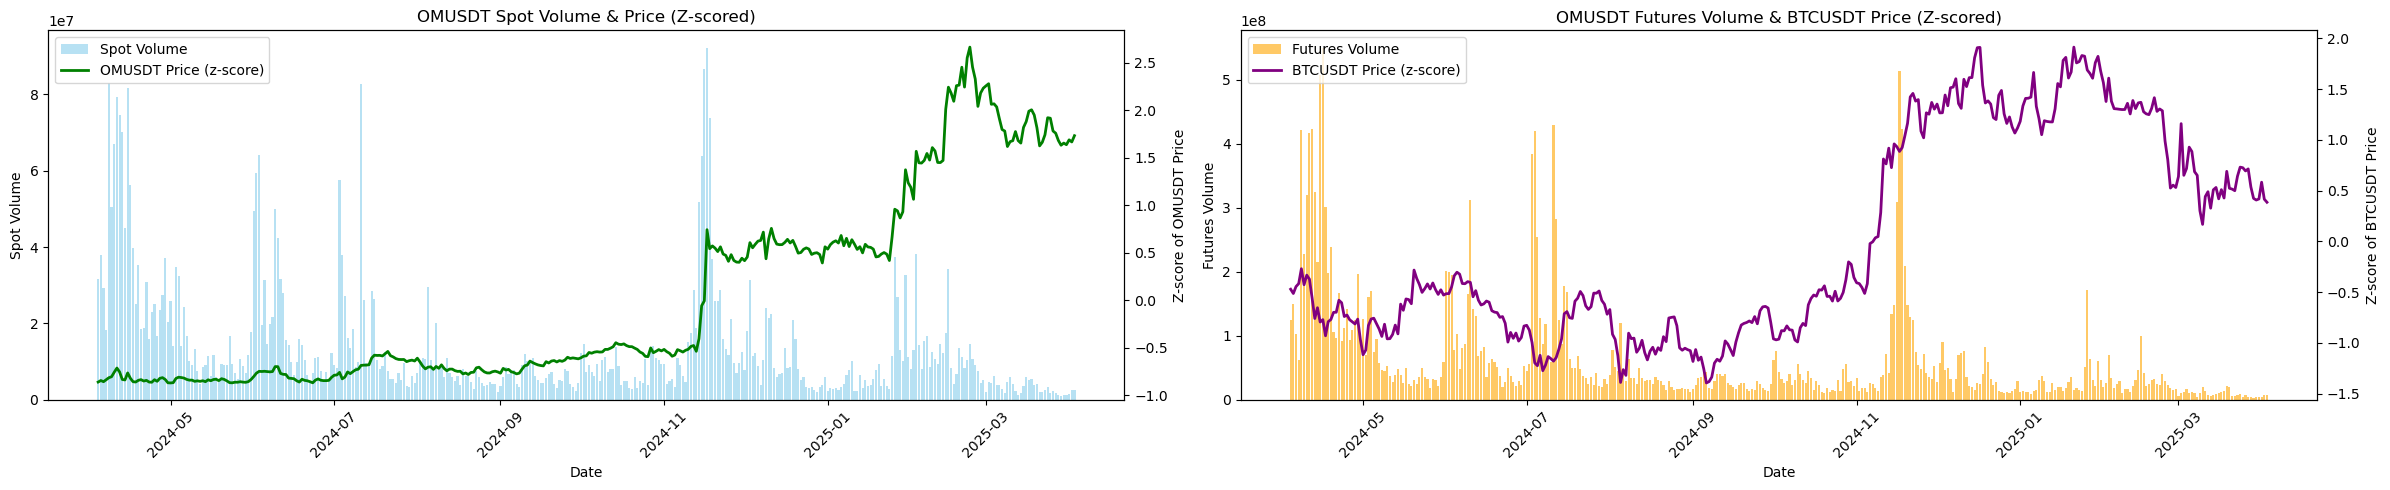

In [110]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil, sqrt

# === CONFIGURATION ===
symbols = ["OMUSDT"]  # The symbol for which we'll plot data (EOSUSDT spot/futures)
interval = "1d"
limit = 365  # Number of days

# === Fetch Spot Data (Volume and Close Price) ===
def fetch_spot_data(symbol, interval, limit):
    url = "https://api.binance.com/api/v3/klines"
    params = {"symbol": symbol, "interval": interval, "limit": limit}
    response = requests.get(url, params=params)
    data = response.json()
    
    df = pd.DataFrame(data, columns=[
        "Open Time", "Open", "High", "Low", "Close", "Volume",
        "Close Time", "Quote Asset Volume", "Number of Trades",
        "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore"
    ])
    df["Date"] = pd.to_datetime(df["Open Time"], unit='ms')
    df["Volume"] = df["Volume"].astype(float)
    df["Close"] = df["Close"].astype(float)
    return df[["Date", "Close", "Volume"]]

# === Fetch USDT-margined Futures Data (Volume and Close Price) ===
def fetch_futures_data(symbol, interval, limit):
    url = "https://fapi.binance.com/fapi/v1/klines"
    params = {"symbol": symbol, "interval": interval, "limit": limit}
    response = requests.get(url, params=params)
    data = response.json()
    
    df = pd.DataFrame(data, columns=[
        "Open Time", "Open", "High", "Low", "Close", "Volume",
        "Close Time", "Quote Asset Volume", "Number of Trades",
        "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore"
    ])
    df["Date"] = pd.to_datetime(df["Open Time"], unit='ms')
    df["Volume"] = df["Volume"].astype(float)
    df["Close"] = df["Close"].astype(float)
    return df[["Date", "Close", "Volume"]]

# === Fetch BTCUSDT Futures Data (for Price Overlay) ===
def fetch_btc_futures_data(interval, limit):
    # Use BTCUSDT as the symbol for futures data.
    return fetch_futures_data("BTCUSDT", interval, limit)

# === Z-score Calculation ===
def compute_zscore(series):
    return (series - series.mean()) / series.std()

# === Plotting ===
num_symbols = len(symbols)
cols = 2  # Two charts side by side
rows = len(symbols)  # One row per symbol

fig, axs = plt.subplots(rows, cols, figsize=(12 * cols, 5 * rows))

# For a single symbol, plt.subplots returns a 1D array; ensure it is a list.
if rows == 1:
    axs = list(axs)

# Fetch BTCUSDT futures data once for the price overlay on the futures chart.
df_btc = fetch_btc_futures_data(interval, limit)
# Compute z-score for BTCUSDT price.
df_btc["z_Close"] = compute_zscore(df_btc["Close"])

for i, symbol in enumerate(symbols):
    try:
        # Fetch EOSUSDT spot data (includes close price and volume)
        df_spot = fetch_spot_data(symbol, interval, limit)
        # Fetch EOSUSDT futures data for volume (if needed)
        df_futures = fetch_futures_data(symbol, interval, limit)
        
        # Compute z-score for EOSUSDT spot price.
        df_spot["z_Close"] = compute_zscore(df_spot["Close"])
        
        # For a single symbol, axs is a 1D list; for multiple symbols, use 2D indexing.
        if rows == 1:
            ax_spot = axs[0]      # Left chart: Spot Volume & EOSUSDT Price
            ax_futures = axs[1]   # Right chart: Futures Volume & BTCUSDT Price
        else:
            ax_spot = axs[i, 0]
            ax_futures = axs[i, 1]
        
        # --- Left Chart: Spot Volume & EOSUSDT Price (Z-scored) ---
        # Plot Spot Volume as a bar chart
        ax_spot.bar(df_spot["Date"], df_spot["Volume"], width=0.8, alpha=0.6,
                    label="Spot Volume", color="skyblue")
        ax_spot.set_title(f"{symbol} Spot Volume & Price (Z-scored)")
        ax_spot.set_xlabel("Date")
        ax_spot.set_ylabel("Spot Volume")
        ax_spot.tick_params(axis='x', rotation=45)
        
        # Overlay EOSUSDT price (z-scored) on a secondary y-axis
        ax_spot_price = ax_spot.twinx()
        ax_spot_price.plot(df_spot["Date"], df_spot["z_Close"], label=f"{symbol} Price (z-score)", 
                           color="green", linewidth=2)
        ax_spot_price.set_ylabel(f"Z-score of {symbol} Price")
        
        # Combine legends for the spot chart
        lines1, labels1 = ax_spot.get_legend_handles_labels()
        lines2, labels2 = ax_spot_price.get_legend_handles_labels()
        ax_spot.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
        
        # --- Right Chart: Futures Volume & BTCUSDT Price (Z-scored) ---
        # Plot Futures Volume as a bar chart (for EOSUSDT futures)
        ax_futures.bar(df_futures["Date"], df_futures["Volume"], width=0.8, alpha=0.6,
                       label="Futures Volume", color="orange")
        ax_futures.set_title(f"{symbol} Futures Volume & BTCUSDT Price (Z-scored)")
        ax_futures.set_xlabel("Date")
        ax_futures.set_ylabel("Futures Volume")
        ax_futures.tick_params(axis='x', rotation=45)
        
        # Overlay BTCUSDT futures price (z-scored) on a secondary y-axis
        ax_btc = ax_futures.twinx()
        ax_btc.plot(df_btc["Date"], df_btc["z_Close"], label="BTCUSDT Price (z-score)", 
                    color="purple", linewidth=2)
        ax_btc.set_ylabel("Z-score of BTCUSDT Price")
        
        # Combine legends for the futures chart
        lines_f, labels_f = ax_futures.get_legend_handles_labels()
        lines_b, labels_b = ax_btc.get_legend_handles_labels()
        ax_futures.legend(lines_f + lines_b, labels_f + labels_b, loc="upper left")
        
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        try:
            if rows == 1:
                if len(axs) >= 2:
                    fig.delaxes(axs[0])
                    fig.delaxes(axs[1])
            else:
                fig.delaxes(axs[i, 0])
                fig.delaxes(axs[i, 1])
        except Exception as del_err:
            print("Error deleting axes:", del_err)

plt.tight_layout()
plt.show()


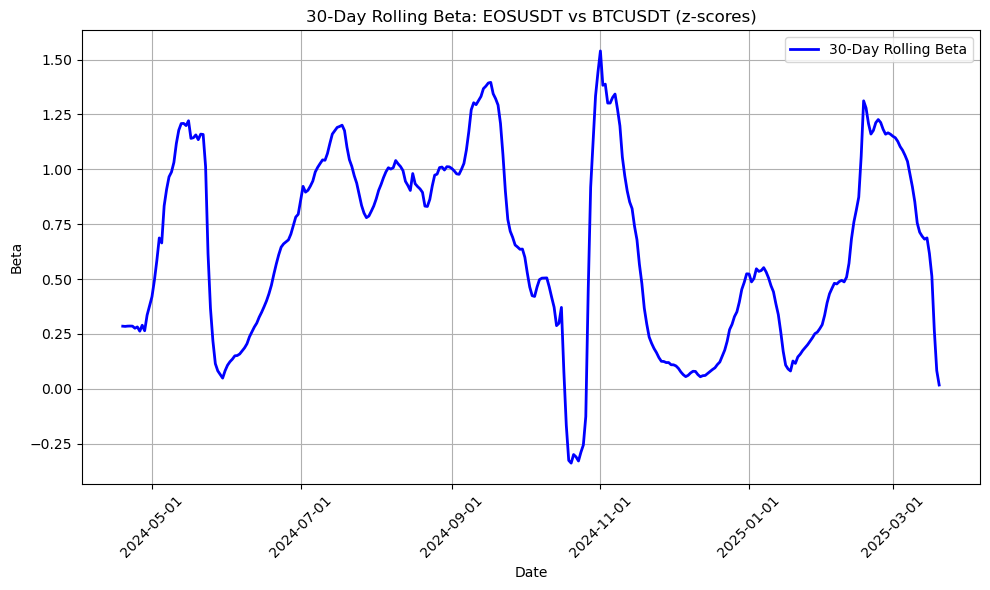

In [113]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === CONFIGURATION ===
om_symbol = "EOSUSDT"  # Use OM for rolling beta
btc_symbol = "BTCUSDT"  # We'll use BTCUSDT futures for comparison
interval = "1d"
limit = 365  # Number of days
window = 30  # Rolling window in days

# === Fetch Spot Data (Volume and Close Price) for OMUSDT ===
def fetch_spot_data(symbol, interval, limit):
    url = "https://api.binance.com/api/v3/klines"
    params = {"symbol": symbol, "interval": interval, "limit": limit}
    response = requests.get(url, params=params)
    data = response.json()
    
    df = pd.DataFrame(data, columns=[
        "Open Time", "Open", "High", "Low", "Close", "Volume",
        "Close Time", "Quote Asset Volume", "Number of Trades",
        "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore"
    ])
    df["Date"] = pd.to_datetime(df["Open Time"], unit='ms')
    df["Close"] = df["Close"].astype(float)
    return df[["Date", "Close"]]

# === Fetch Futures Data (Volume and Close Price) for BTCUSDT ===
def fetch_futures_data(symbol, interval, limit):
    url = "https://fapi.binance.com/fapi/v1/klines"
    params = {"symbol": symbol, "interval": interval, "limit": limit}
    response = requests.get(url, params=params)
    data = response.json()
    
    df = pd.DataFrame(data, columns=[
        "Open Time", "Open", "High", "Low", "Close", "Volume",
        "Close Time", "Quote Asset Volume", "Number of Trades",
        "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore"
    ])
    df["Date"] = pd.to_datetime(df["Open Time"], unit='ms')
    df["Close"] = df["Close"].astype(float)
    return df[["Date", "Close"]]

# --- Fetch data for OMUSDT (spot) and BTCUSDT (futures)
df_om = fetch_spot_data(om_symbol, interval, limit)
df_btc = fetch_futures_data(btc_symbol, interval, limit)

# --- Merge the data on Date
merged = pd.merge(df_om.rename(columns={"Close": "OM_Close"}),
                  df_btc.rename(columns={"Close": "BTC_Close"}),
                  on="Date", how="inner")
merged.sort_values("Date", inplace=True)
merged.set_index("Date", inplace=True)

# --- Compute z-scores for each price series
merged["z_OM"] = (merged["OM_Close"] - merged["OM_Close"].mean()) / merged["OM_Close"].std()
merged["z_BTC"] = (merged["BTC_Close"] - merged["BTC_Close"].mean()) / merged["BTC_Close"].std()

# --- Define function to compute rolling regression slope (beta)
def rolling_regression_slope(series_x, series_y, window):
    slopes = []
    dates = []
    for i in range(len(series_x) - window + 1):
        x_window = series_x.iloc[i:i+window]
        y_window = series_y.iloc[i:i+window]
        slope, intercept = np.polyfit(x_window, y_window, 1)
        slopes.append(slope)
        dates.append(series_x.index[i + window // 2])
    return pd.Series(slopes, index=dates)

# --- Compute the rolling regression slope between z_OM and z_BTC
rolling_beta = rolling_regression_slope(merged["z_OM"], merged["z_BTC"], window)

# --- Plot the 30-Day Rolling Beta with normal date formatting
plt.figure(figsize=(10, 6))
plt.plot(rolling_beta.index, rolling_beta.values, label="30-Day Rolling Beta", color="blue", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Beta")
plt.title(f"30-Day Rolling Beta: {om_symbol} vs {btc_symbol} (z-scores)")
plt.legend()
plt.grid(True)

# Format x-axis dates
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


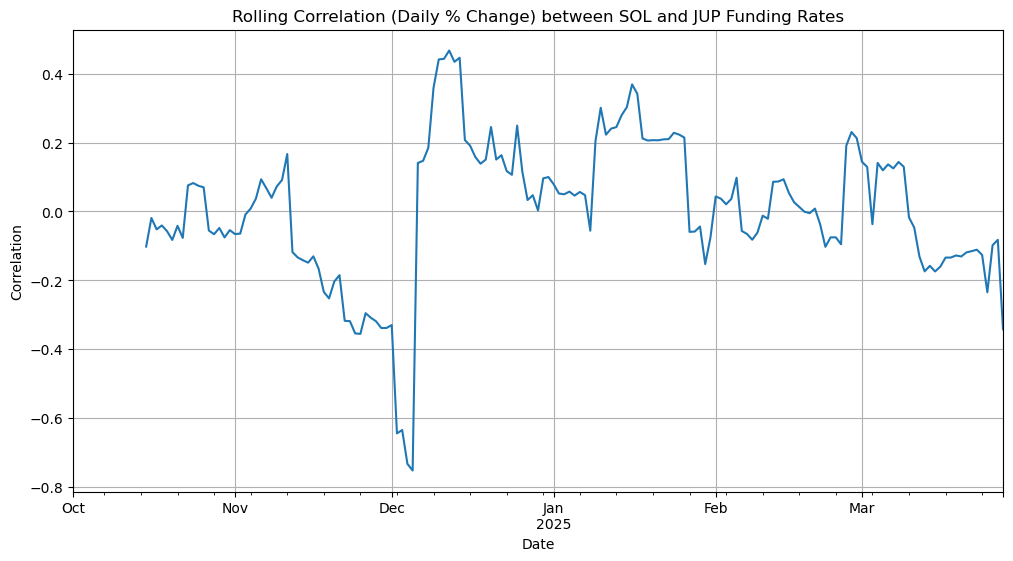

In [123]:
# Assume jup_df and btc_df are DataFrames with a datetime index and a "Funding Rate" column.
# Resample each to daily frequency (mean of the day's rates)
sol_daily = binance_data["SOLUSDT"]["Funding Rate"].resample('D').mean()
jup_daily = binance_data["JUPUSDT"]["Funding Rate"].resample("D").mean()

# Compute daily percentage changes in funding rates
sol_pct = sol_daily.pct_change()
jup_pct = jup_daily.pct_change()

# Merge the daily percentage change series (inner join to keep only overlapping days)
merged_pct = pd.concat([sol_pct, jup_pct], axis=1, join="inner")
merged_pct.columns = ["SOL_pct", "JUP_pct"]

# Compute rolling correlation over a window of, say, 14 days.
rolling_corr_daily = merged_pct["SOL_pct"].rolling(window=14).corr(merged_pct["JUP_pct"])

# Plot daily rolling correlation of percentage changes
rolling_corr_daily.plot(figsize=(12,6), title="Rolling Correlation (Daily % Change) between SOL and JUP Funding Rates")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.grid(True)
plt.show()



# Monthly simulation

In [52]:
import numpy as np
import pandas as pd
from scipy.stats import t as student_t

try:
    import numpy_financial as npf
except ImportError:
    npf = None

def simulate_strategy(
    P0, investment_amount, discount, hedge_ratio, T, annual_vol, annual_funding_rate,
    cliff_months=0, price_floor=None, seed=None, external_shocks=None
):
    if seed is not None:
        np.random.seed(seed)

    Q = investment_amount / (P0 * (1 - discount))

    # === Price Simulation Setup ===
    price_outlook = "bearish"
    outlook_drifts = {"bearish": -0.10, "neutral": 0.00, "bullish": 0.10}
    mu = np.log(1 + outlook_drifts.get(price_outlook, 0.0))
    dt = 1 / 12.0
    prices = [P0]

    # Fat-tailed shocks: if external shocks are provided, use them; else, generate new ones.
    df_t = 3.0
    skew_strength = 0.0
    if external_shocks is not None:
        shocks = external_shocks
    else:
        shocks = student_t.rvs(df_t, size=T)
        shocks /= np.sqrt(df_t / (df_t - 2))
        shocks = np.where(shocks >= 0, shocks * (1 + skew_strength), shocks * (1 - skew_strength))

    for Z in shocks:
        last_price = prices[-1]
        Pt = last_price * np.exp((mu - 0.5 * annual_vol**2) * dt + annual_vol * np.sqrt(dt) * Z)
        prices.append(max(Pt, price_floor) if price_floor is not None else Pt)

    # === Initialize Strategy Variables ===
    details = []
    collateral_series = []

    token_cost = Q * P0 * (1 - discount)
    hedged_tokens = hedge_ratio * Q
    unhedged_tokens = Q - hedged_tokens
    initial_collateral = (1 / 3) * (hedged_tokens * P0)
    cf0 = -token_cost - initial_collateral

    details.append({
        "time": 0.0, "month": 0, "price": P0,
        "remaining_long": Q, "remaining_short": hedged_tokens,
        "collateral": initial_collateral, "collateral_flow": -initial_collateral,
        "funding_cash_flow": 0.0, "hedged_sale_flow": 0.0, "hedged_cover_flow": 0.0,
        "unhedged_sale_flow": 0.0, "vesting_total_flow": 0.0,
        "total_cf": cf0, "note": "Initial Setup"
    })

    remaining_long = Q
    remaining_short = hedged_tokens
    collateral = initial_collateral
    total_funding_cost = 0.0
    vest_months = max(T - cliff_months, 1)
    vest_per_month = Q / vest_months

    monthly_cash_flows = []

    # === Monthly Simulation Loop ===
    for t in range(1, T + 1):
        time_year = t / 12.0
        price_prev = prices[t - 1]
        current_price = prices[t]

        new_collateral_required = (1 / 3) * (remaining_short * price_prev)
        collateral_change = new_collateral_required - collateral
        collateral_flow = -collateral_change
        collateral = new_collateral_required
        collateral_series.append(collateral)

        notional = remaining_short * price_prev
        funding_cost = (annual_funding_rate / 12.0) * notional
        total_funding_cost += funding_cost

        if t > cliff_months:
            vested = vest_per_month
        else:
            vested = 0.0

        tokens_hedged_vesting = min(vested, remaining_short)
        hedged_sale_flow = tokens_hedged_vesting * current_price
        hedged_cover_flow = tokens_hedged_vesting * (P0 - current_price)
        net_hedged = hedged_sale_flow + hedged_cover_flow

        tokens_unhedged = vested - tokens_hedged_vesting
        unhedged_sale_flow = tokens_unhedged * current_price

        vesting_total_flow = net_hedged + unhedged_sale_flow

        remaining_short -= tokens_hedged_vesting
        remaining_long -= vested

        total_cf_month = collateral_flow + funding_cost + vesting_total_flow

        details.append({
            "time": time_year, "month": t, "price": current_price,
            "remaining_long": remaining_long, "remaining_short": remaining_short,
            "collateral": collateral, "collateral_flow": collateral_flow,
            "funding_cash_flow": funding_cost,
            "hedged_sale_flow": hedged_sale_flow,
            "hedged_cover_flow": hedged_cover_flow,
            "unhedged_sale_flow": unhedged_sale_flow,
            "vesting_total_flow": vesting_total_flow,
            "total_cf": total_cf_month,
            "note": f"Month {t} vesting: hedged {tokens_hedged_vesting:.2f}, unhedged {tokens_unhedged:.2f}"
        })

        monthly_cash_flows.append((time_year, total_cf_month))

    # === Final Settlement ===
    final_time = T / 12.0
    final_price = prices[-1]
    final_sale = remaining_long * final_price
    final_short_settlement = remaining_short * (P0 - final_price) if remaining_short > 0 else 0.0
    collateral_release = collateral
    final_total_cf = final_sale + final_short_settlement + collateral_release

    details.append({
        "time": final_time, "month": T, "price": final_price,
        "remaining_long": 0.0, "remaining_short": 0.0, "collateral": 0.0,
        "collateral_flow": collateral_release,
        "funding_cash_flow": 0.0, "hedged_sale_flow": 0.0,
        "hedged_cover_flow": final_short_settlement,
        "unhedged_sale_flow": final_sale,
        "vesting_total_flow": final_sale + final_short_settlement,
        "total_cf": final_total_cf,
        "note": "Final Settlement"
    })

    cash_flows = [(row["time"], row["total_cf"]) for row in details]
    values_arr = np.array([cf for t, cf in cash_flows])
    irr = npf.irr(values_arr) if npf else None
    monthly_irr = irr
    annual_irr = (1 + monthly_irr)**12 - 1 if monthly_irr is not None else None
    total_pnl = np.sum(values_arr)
    df_details = pd.DataFrame(details)

    return {
        "prices": prices,
        "collateral_series": collateral_series,
        "cash_flows": cash_flows,
        "IRR": irr,
        "Total_PnL": total_pnl,
        "Total_Funding_Cost": total_funding_cost,
        "simulation_details": df_details,
        "Annualized IRR": annual_irr
    }
# --- Example Run ---
if __name__ == "__main__":
    results = simulate_strategy(
     P0=0.7870,                    # initial token price
        investment_amount=1000000,  # total cash to invest
        discount=0.40,              # 25% discount
        hedge_ratio=1,            # hedge 50% of tokens at entry
        T=24,                     # vesting over 22 months
        annual_vol=1.01,            # annualized volatility of 131%
        annual_funding_rate=0.05,   # 10% annual funding cost (we pay funding)
        cliff_months=12,             # no cliff (vesting starts immediately)
        #price_floor=0.15,
        seed=42                     # reproducibility
    )
    
    print("IRR:", results["Annualized IRR"])
    print("Total PnL:", results["Total_PnL"])
    print("\nMonthly Simulation Details:")
    print(results["simulation_details"])
    print("\nPrice Path:")
    print(results["prices"])
    print("\nCash Flows (time in years, cash):")
    for t, cf in results["cash_flows"]:
        print(f"t = {t:.2f} years: {cf:.2f}")


IRR: 0.32880644599057995
Total PnL: 757597.3339229478

Monthly Simulation Details:
        time  month     price  remaining_long  remaining_short     collateral  \
0   0.000000      0  0.787000    2.117747e+06     2.117747e+06  555555.555556   
1   0.083333      1  0.827295    2.117747e+06     2.117747e+06  555555.555556   
2   0.166667      2  0.653619    2.117747e+06     2.117747e+06  584000.579062   
3   0.250000      3  0.773076    2.117747e+06     2.117747e+06  461399.688303   
4   0.333333      4  0.635583    2.117747e+06     2.117747e+06  545726.074327   
5   0.416667      5  0.720157    2.117747e+06     2.117747e+06  448668.127825   
6   0.500000      6  1.024937    2.117747e+06     2.117747e+06  508370.036363   
7   0.583333      7  0.646830    2.117747e+06     2.117747e+06  723518.939703   
8   0.666667      8  0.559808    2.117747e+06     2.117747e+06  456607.129640   
9   0.750000      9  0.481795    2.117747e+06     2.117747e+06  395177.087157   
10  0.833333     10  0.423

In [ ]:
# Rename existing columns to match desired export format
df_full = results["simulation_details"].copy()

# Map actual columns to your desired schema
df_full = df_full.rename(columns={
    "month": "day",  # treating month as 'day' placeholder
    "note": "event",
    "hedged_sale_flow": "spot_sale_flow",
    "hedged_cover_flow": "hedge_profit_flow",
    "total_cf": "cash_flow"
})

# Add missing columns with zeros if they weren't in the original
for col in [
    "event", "spot_sale_flow", "hedge_profit_flow", "cash_flow",
    "day"  # required if 'month' renamed
]:
    if col not in df_full.columns:
        df_full[col] = 0

# Reorder and select only desired columns
all_columns = [
    "time", "day", "event", "price", "remaining_long", "remaining_short", 
    "collateral", "collateral_flow", "funding_cash_flow", 
    "spot_sale_flow", "hedge_profit_flow", "unhedged_sale_flow", 
    "vesting_total_flow", "cash_flow"
]

df_full = df_full.reindex(columns=all_columns)
df_full = df_full.fillna(0)

# Save to CSV
df_full.to_csv("simulation_details_full.csv", index=False)
print("Saved to simulation_details_full.csv")


Saved to simulation_details_full.csv


# Daily simulation

In [13]:
import numpy as np
import pandas as pd
from scipy.stats import t as student_t


# Try to import numpy_financial for IRR calculation.
try:
    import numpy_financial as npf
except ImportError:
    npf = None

from scipy.optimize import newton

def xnpv(rate, cash_flows):
    """Compute NPV for irregular cash flows."""
    return sum(cf / (1 + rate) ** t for t, cf in cash_flows)

def xirr(cash_flows, guess=0.1):
    """Compute IRR for irregular cash flows using Newton's method."""
    return newton(lambda r: xnpv(r, cash_flows), guess)

def simulate_strategy_daily(P0, investment_amount, discount, hedge_ratio, T, annual_vol, annual_funding_rate,
                            cliff_months=0, price_floor=None, seed=None, external_shocks=None):
    """
    Simulate the trading strategy on a daily basis (365 days/year) with vesting events on the last day of each month.
    
    Returns a dictionary containing:
      - "prices": daily price path (list).
      - "cash_flows": overall cash flows (list of (time in years, amount)).
      - "IRR": internal rate of return computed using numpy_financial.irr.
      - "XIRR": internal rate of return computed using a custom function.
      - "ROI": return on investment in percent.
      - "Total_PnL": total profit/loss.
      - "Total_Funding_Cost": cumulative funding cost.
      - "simulation_details": DataFrame with daily details.
    """
    if seed is not None:
        np.random.seed(seed)

    # Calculate total tokens purchased.
    Q = investment_amount / (P0 * (1 - discount))
    dt = 1 / 365.0  # daily time step (years)
    total_days = T * 30  # assume each month is 30 days

    # === Configurable Price Outlook ===
    price_outlook = "bearish"  # Options: "bearish", "neutral", "bullish"
    outlook_drifts = {
        "bearish": -0.10,
        "neutral":  0.00,
        "bullish":  0.10
    }
    mu_annual = np.log(1 + outlook_drifts.get(price_outlook, 0.0))

    # === Fat-tailed Shock Settings ===
    df_t = 3.0               # Degrees of freedom for t-distribution
    skew_strength = 0.0      # Adjust for asymmetric returns

    # === Simulate Price Path ===
    if external_shocks is not None:
        # Use pre-generated shocks
        shocks = external_shocks
    else:
        # Generate new shocks if none provided
        shocks = student_t.rvs(df_t, size=total_days)
        shocks /= np.sqrt(df_t / (df_t - 2))
        shocks = np.where(shocks >= 0, shocks * (1 + skew_strength), shocks * (1 - skew_strength))


    # Optional skew
    shocks = np.where(shocks >= 0, shocks * (1 + skew_strength), shocks * (1 - skew_strength))

    # Daily drift and diffusion
    drift = (mu_annual - 0.5 * annual_vol**2) * dt
    diffusion = annual_vol * np.sqrt(dt) * shocks

    # Log return process
    log_returns = drift + diffusion
    log_prices = np.cumsum(log_returns)
    log_prices = np.insert(log_prices, 0, 0.0)

    # Final price path
    prices = P0 * np.exp(log_prices)
    if price_floor is not None:
        prices = np.maximum(prices, price_floor)
    prices = prices.tolist()
    
    details = []
    # --- Time 0: Initial Setup ---
    hedged_tokens = hedge_ratio * Q
    unhedged_tokens = Q - hedged_tokens
    initial_collateral = (1 / 3) * (hedged_tokens * P0)
    cf0 = - (Q * P0 * (1 - discount)) - initial_collateral

    details.append({
        "time": 0.0,
        "day": 0,
        "event": "Initial Setup",
        "price": P0,
        "remaining_long": Q,
        "remaining_short": hedged_tokens,
        "collateral": initial_collateral,
        "collateral_flow": 0.0,
        "funding_cash_flow": 0.0,
        "hedged_sale_flow": 0.0,
        "hedged_cover_flow": 0.0,
        "unhedged_sale_flow": 0.0,
        "vesting_total_flow": 0.0,
        "cash_flow": cf0
    })

    remaining_long = Q         # tokens held long
    remaining_short = hedged_tokens  # tokens to be covered via vesting
    collateral = initial_collateral
    total_funding_cost = 0.0

    # Vesting schedule: vest_per_month tokens vest each month (after cliff)
    vesting_events = T - cliff_months if (T - cliff_months) > 0 else T
    vest_per_month = Q / vesting_events

    times = [0.0]
    cash_flows = [cf0]
    daily_cash_flows = []

    # --- Daily Simulation Loop ---
    for day in range(1, total_days + 1):
        time_year = day / 365.0
        price_prev = prices[day - 1]
        current_price = prices[day]

        # 1. Collateral Rebalancing:
        new_collateral = (1 / 3) * (remaining_short * price_prev)
        collateral_flow = -(new_collateral - collateral)
        collateral = new_collateral

        # 2. Funding Cost:
        notional = remaining_short * price_prev
        funding_cost = (annual_funding_rate / 365.0) * notional
        funding_cash_flow = funding_cost
        total_funding_cost += funding_cost

        # 3. Vesting: Initialize all vesting-related variables to zero.
        spot_sale_flow = 0.0
        derivative_profit = 0.0
        unhedged_sale_flow = 0.0
        vesting_total_flow = 0.0
        vest_event_note = "No vesting"
        tokens_hedged = 0.0  # Ensure variable exists
        vested = 0.0         # Ensure variable exists

        if day % 30 == 0:
            current_month = day // 30  # 1-indexed month count
            if current_month > cliff_months:
                vested = vest_per_month
            else:
                vested = 0.0

            if vested > 0:
                tokens_hedged = min(vested, remaining_short)
                # For hedged portion:
                # Sell the received spot tokens at current market price.
                spot_sale_flow = tokens_hedged * current_price
                # Close the derivative short (i.e. realize profit/loss) at entry price P0.
                derivative_profit = tokens_hedged * (P0 - current_price)
                # The net hedged cash flow is then:
                net_hedged = spot_sale_flow + derivative_profit  # equals tokens_hedged * P0

                # For unhedged portion:
                tokens_unhedged = vested - tokens_hedged
                unhedged_sale_flow = tokens_unhedged * current_price

                vesting_total_flow = net_hedged + unhedged_sale_flow

                remaining_short -= tokens_hedged
                remaining_long -= vested

                vest_event_note = f"Vesting: hedged {tokens_hedged:.2f}, unhedged {tokens_unhedged:.2f}"

        total_cf_day = collateral_flow + funding_cash_flow + vesting_total_flow
        times.append(time_year)
        cash_flows.append(total_cf_day)
        daily_cash_flows.append((time_year, total_cf_day))

        details.append({
            "time": time_year,
            "day": day,
            "event": vest_event_note,
            "price": current_price,
            "remaining_long": remaining_long,
            "remaining_short": remaining_short,
            "collateral": collateral,
            "collateral_flow": collateral_flow,
            "funding_cash_flow": funding_cash_flow,
            "hedged_sale_flow": (tokens_hedged * P0) if (day % 30 == 0 and vested > 0) else 0.0,
            "hedged_cover_flow": (tokens_hedged * current_price) if (day % 30 == 0 and vested > 0) else 0.0,
            "unhedged_sale_flow": unhedged_sale_flow,
            "vesting_total_flow": vesting_total_flow,
            "cash_flow": total_cf_day
        })

    # --- Final Settlement ---
    final_time = total_days / 365.0
    final_sale = remaining_long * prices[-1]
    final_short_settlement = - (remaining_short * prices[-1]) if remaining_short > 0 else 0.0
    final_collateral = collateral  # release remaining collateral
    final_total_cf = final_sale + final_short_settlement + final_collateral

    times.append(final_time)
    cash_flows.append(final_total_cf)
    details.append({
        "time": final_time,
        "day": total_days,
        "event": "Final Settlement",
        "price": prices[-1],
        "remaining_long": 0.0,
        "remaining_short": 0.0,
        "collateral": 0.0,
        "collateral_flow": 0.0,
        "funding_cash_flow": 0.0,
        "hedged_sale_flow": 0.0,
        "hedged_cover_flow": 0.0,
        "unhedged_sale_flow": 0.0,
        "vesting_total_flow": 0.0,
        "cash_flow": final_total_cf
    })

    # Sort cash flows by time and compute IRR.
    cash_flows = sorted(list(zip(np.array(times), np.array(cash_flows))), key=lambda x: x[0])
    times_arr = np.array([t for t, cf in cash_flows])
    values_arr = np.array([cf for t, cf in cash_flows])
    if npf is not None:
        irr = npf.irr(values_arr)
    else:
        irr = np.irr(values_arr) if hasattr(np, "irr") else None

    total_pnl = np.sum(values_arr)
    initial_investment = -details[0]["cash_flow"]
    ROI = (total_pnl / initial_investment) * 100

    try:
        xirr_value = xirr(cash_flows, guess=0.1)
    except Exception as e:
        xirr_value = None

    df_details = pd.DataFrame(details)

    return {
        "prices": prices,
        "cash_flows": cash_flows,
        "IRR": irr,
        "XIRR": xirr_value,
        "ROI": ROI,
        "Total_PnL": total_pnl,
        "Total_Funding_Cost": total_funding_cost,
        "simulation_details": df_details
    }


# --- Example Run with Daily Simulation ---
results_daily = simulate_strategy_daily(
    P0=0.7870,                    # initial token price
    investment_amount=1000000,  # total cash to invest
    discount=0.30,              # 25% discount
    hedge_ratio=0.5,            # hedge 50% of tokens at entry
    T=24,                     # vesting over 22 months
    annual_vol=1.01,            # annualized volatility of 131%
    annual_funding_rate=0.05,   # 10% annual funding cost (we pay funding)
    cliff_months=12,             # no cliff (vesting starts immediately)
    #price_floor=0.15,
    seed=42                     # reproducibility
)

print("IRR:", results_daily["IRR"])
print("XIRR:", results_daily["XIRR"])
print("ROI:", results_daily["ROI"])
print("Total PnL:", results_daily["Total_PnL"])
print("\nDaily Simulation Details (last 10 rows):")
print(results_daily["simulation_details"].tail(10))

print("\nPrice Path (first 20 days):")
print(results_daily["prices"][:21])
print("\nCash Flows (first 20 days):")
for t, cf in results_daily["cash_flows"][:20]:
    print(f"t = {t:.4f} years: {cf:.2f}")

IRR: -0.0003881072558252763
XIRR: -0.08159875172550039
ROI: -9.654979036192518
Total PnL: -119537.83568619308

Daily Simulation Details (last 10 rows):
         time  day                                     event     price  \
712  1.950685  712                                No vesting  0.131647   
713  1.953425  713                                No vesting  0.120359   
714  1.956164  714                                No vesting  0.110249   
715  1.958904  715                                No vesting  0.108913   
716  1.961644  716                                No vesting  0.111043   
717  1.964384  717                                No vesting  0.107493   
718  1.967123  718                                No vesting  0.108172   
719  1.969863  719                                No vesting  0.106015   
720  1.972603  720  Vesting: hedged 0.00, unhedged 151267.62  0.104210   
721  1.972603  720                          Final Settlement  0.104210   

     remaining_long  remaining_sh

# Monte Carlo analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from collections import defaultdict
from scipy.stats import t as student_t

# Define sensitivity parameter ranges.
discounts = np.linspace(0.4,0.4,1)  # Example: 0.2, 0.35, 0.5
hedge_ratios = np.linspace(0.2, 0.8, 3)  # Only one value: 0.8
funding_rates = np.linspace(-0.2, 0.2, 5)  # e.g. -0.2, -0.1, 0.0, 0.1, 0.2
num_runs = 1000   # Number of Monte Carlo runs for each parameter combination
T = 36  # Simulation horizon (months)

# Pre-generate a common set of shocks for each run.
df_t = 3.0
skew_strength = 0.0
common_shocks = {}
for run in range(num_runs):
    shocks = student_t.rvs(df_t, size=T*30)
    shocks /= np.sqrt(df_t / (df_t - 2))
    shocks = np.where(shocks >= 0, shocks * (1 + skew_strength), shocks * (1 - skew_strength))
    common_shocks[run] = shocks

# Build a list of tasks. Each task is one run with a given parameter set.
tasks = []
for discount in discounts:
    for hedge_ratio in hedge_ratios:
        for funding_rate in funding_rates:
            for run in range(num_runs):
                tasks.append((discount, hedge_ratio, funding_rate, run))

total_iterations = len(tasks)
print("Total iterations:", total_iterations)

def run_simulation(discount, hedge_ratio, funding_rate, run):
    # Use the pre-generated shocks for this run.
    external_shocks = common_shocks[run]
    res = simulate_strategy_daily(
        P0=0.4732,
        investment_amount=32800000,
        discount=discount,
        hedge_ratio=hedge_ratio,
        T=T,
        annual_vol=1.0125,
        annual_funding_rate=funding_rate,
        cliff_months=12,
        #price_floor=0.15,  # optional
        seed=None,         # seed not used since we supply external shocks
        external_shocks=external_shocks
    )
    return (
        discount,
        hedge_ratio,
        funding_rate,
        res["IRR"], 
        res["XIRR"], # already annualized in the simulation function
        res["Total_PnL"],
        res["prices"]
    )

# Run simulations in parallel.
results_raw = Parallel(n_jobs=-1, verbose=5)(
    delayed(run_simulation)(discount, hedge_ratio, funding_rate, run)
    for discount, hedge_ratio, funding_rate, run in tqdm(tasks, desc="MC runs", total=total_iterations)
)

# Group results by (discount, hedge_ratio, funding_rate).
detailed_ann_irr = defaultdict(list)
detailed_pnl = defaultdict(list)
detailed_prices = defaultdict(list)
detailed_collateral = defaultdict(list)

for discount, hedge_ratio, funding_rate, ann_irr, xirr, pnl, prices in results_raw:
    key = (round(discount, 3), round(hedge_ratio, 3), round(funding_rate, 3))
    detailed_ann_irr[key].append(ann_irr)
    detailed_pnl[key].append(pnl)
    detailed_prices[key].append(prices)
    detailed_collateral[key].append(collateral)

results_list = []
for key in detailed_ann_irr:
    disc, hedg, fund = key
    irr_list = [x for x in detailed_ann_irr[key] if x is not None]
    pnl_list = detailed_pnl[key]
    xirr_list = [x for x in detailed_ann_irr[key] if x is not None]
    prices_list = detailed_prices[key]
    avg_xirr    = np.mean(xirr_list) if xirr_list else np.nan
    med_xirr    = np.median(xirr_list) if xirr_list else np.nan
    avg_ann_irr = np.mean(irr_list) if irr_list else np.nan
    med_ann_irr = np.median(irr_list) if irr_list else np.nan
    avg_pnl = np.mean(pnl_list) if pnl_list else np.nan
    med_pnl = np.median(pnl_list) if pnl_list else np.nan
    
    results_list.append({
        "discount": disc,
        "hedge_ratio": hedg,
        "funding_rate": fund,
        "avg_Annualized_IRR": avg_ann_irr,
        "median_Annualized_IRR": med_ann_irr,
        "avg_Total_PnL": avg_pnl,
        "median_Total_PnL": med_pnl,
        "num_runs": num_runs
    })

results_df = pd.DataFrame(results_list)
print("Sensitivity Analysis Table:")
print(results_df)


Total iterations: 15000






[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.




/var/folders/td/k0m1s7_n6ps90j1fyg7rqt_c0000gn/T/ipykernel_16070/2249307493.py:16: RuntimeWarning: invalid value encountered in scalar power
/var/folders/td/k0m1s7_n6ps90j1fyg7rqt_c0000gn/T/ipykernel_16070/2249307493.py:16: RuntimeWarning: invalid value encountered in scalar power
/var/folders/td/k0m1s7_n6ps90j1fyg7rqt_c0000gn/T/ipykernel_16070/2249307493.py:16: RuntimeWarning: invalid value encountered in scalar power
/var/folders/td/k0m1s7_n6ps90j1fyg7rqt_c0000gn/T/ipykernel_16070/2249307493.py:16: RuntimeWarning: invalid value encountered in scalar power




/var/folders/td/k0m1s7_n6ps90j1fyg7rqt_c0000gn/T/ipykernel_16070/2249307493.py:16: RuntimeWarning: invalid value encountered in scalar power




/var/folders/td/k0m1s7_n6ps90j1fyg7rqt_c0000gn/T/ipykernel_16070/2249307493.py:16: RuntimeWarning: invalid value encountered in scalar power
/var/folders/td/k0m1s7_n6ps90j1fyg7rqt_c0000gn/T/ipykernel_16

KeyboardInterrupt: 

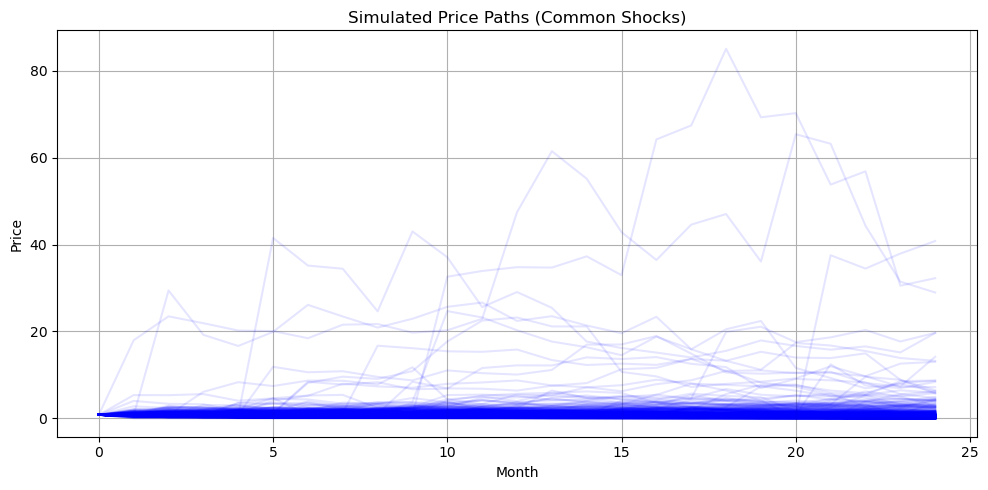

In [54]:
import matplotlib.pyplot as plt

# Plot common price paths from the pre-generated shocks:
plt.figure(figsize=(10, 5))
for run in range(1000):  # or a subset if you prefer
    # Get a price path from one simulation using the common shocks
    # (Assume using one parameter combination, e.g., key=(0.35, 0.8, 0.0))
    prices = detailed_prices[(0.35, 0.8, 0.0)][run]
    plt.plot(prices, alpha=0.1, color='blue')
plt.title("Simulated Price Paths (Common Shocks)")
plt.xlabel("Month")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()


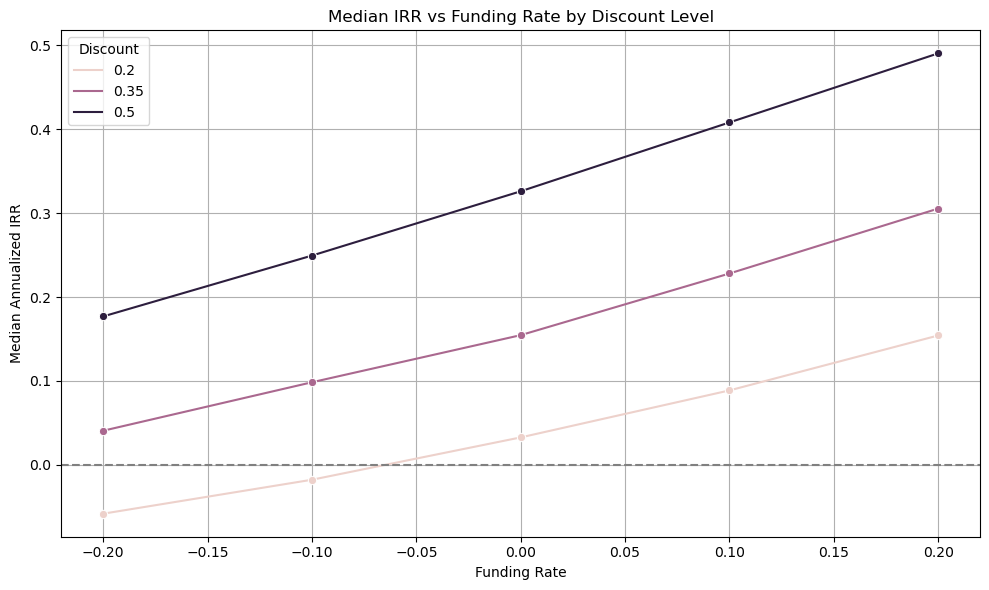

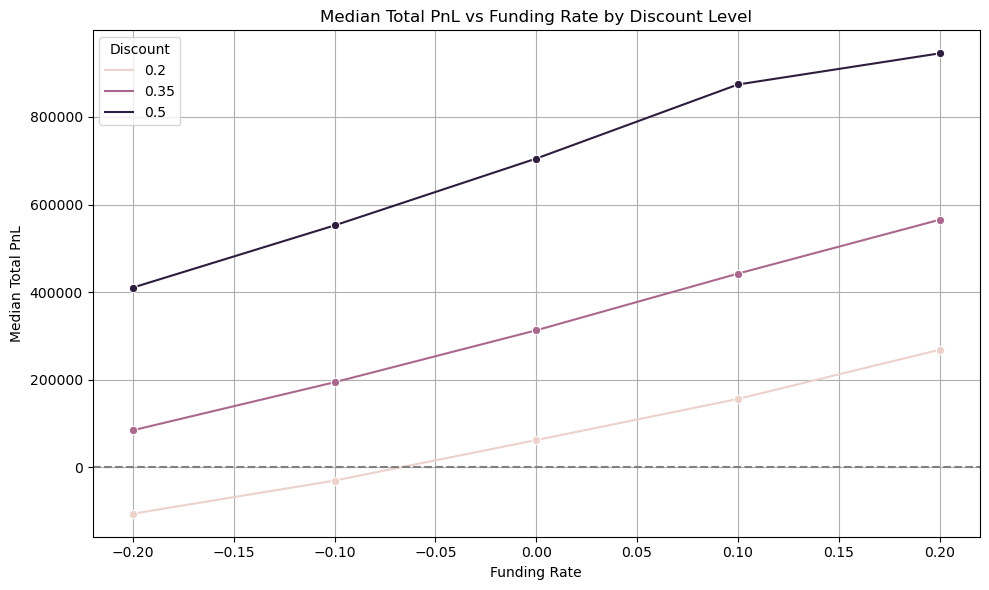

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is called `df`
df = results_df.copy()  # Or whatever your table is called

# --- PLOT 1: Median IRR vs Funding Rate ---
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="funding_rate", y="median_Annualized_IRR", hue="discount", marker="o")
plt.title("Median IRR vs Funding Rate by Discount Level")
plt.xlabel("Funding Rate")
plt.ylabel("Median Annualized IRR")
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True)
plt.legend(title="Discount")
plt.tight_layout()
plt.show()

# --- PLOT 2: Median PnL vs Funding Rate ---
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="funding_rate", y="median_Total_PnL", hue="discount", marker="o")
plt.title("Median Total PnL vs Funding Rate by Discount Level")
plt.xlabel("Funding Rate")
plt.ylabel("Median Total PnL")
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True)
plt.legend(title="Discount")
plt.tight_layout()
plt.show()

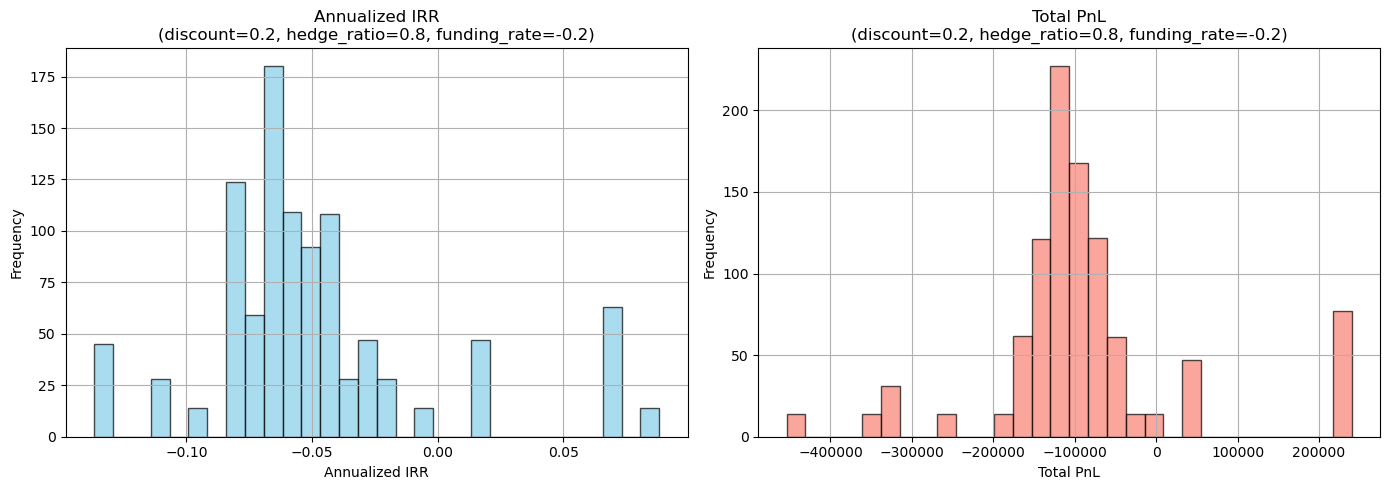

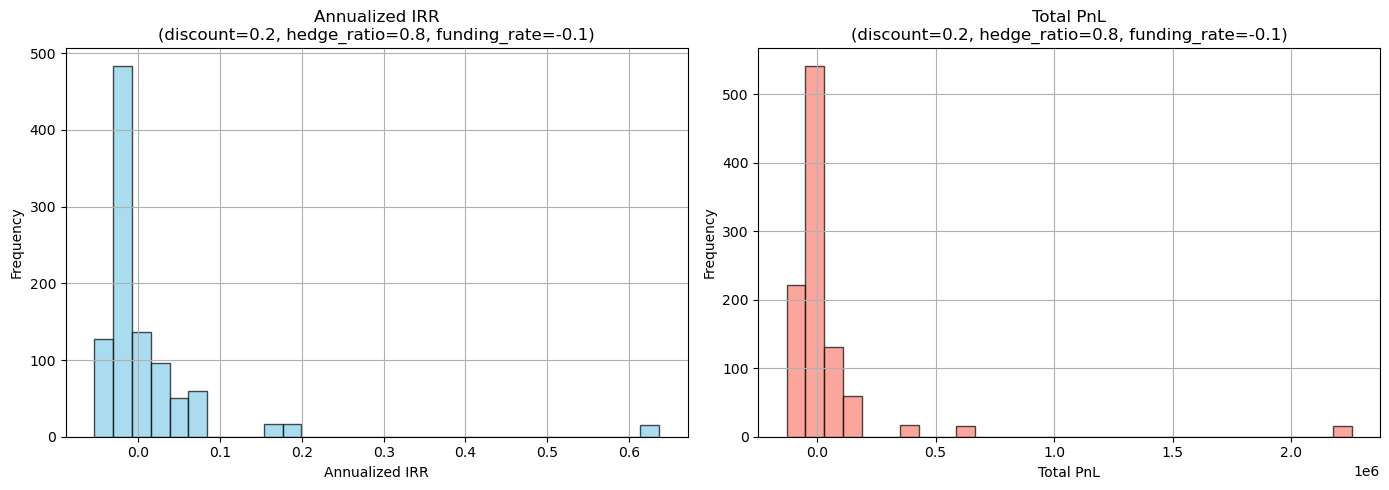

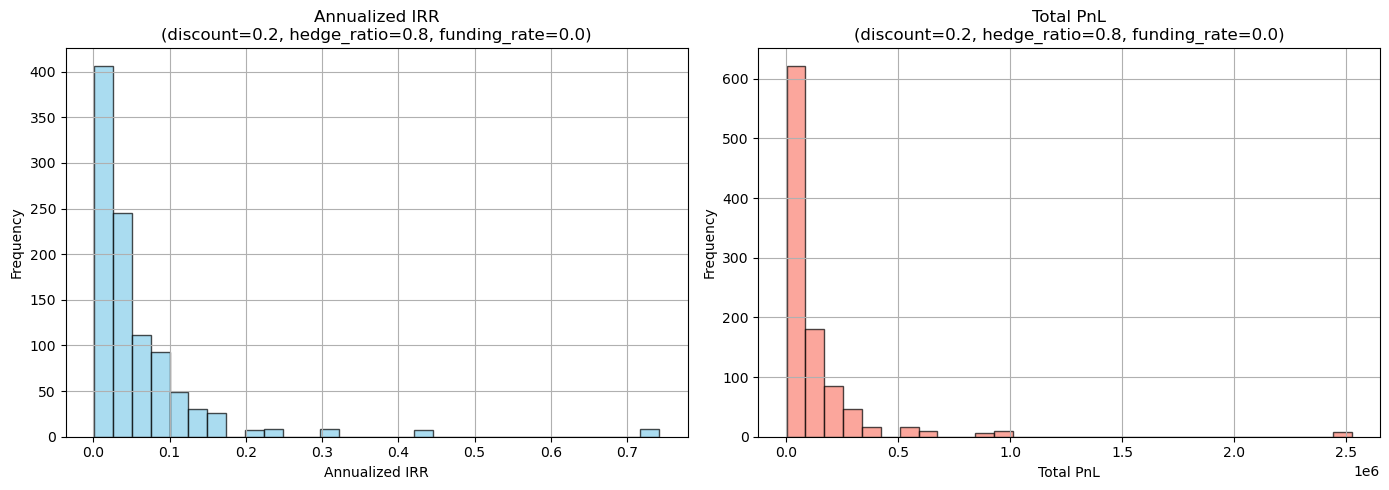

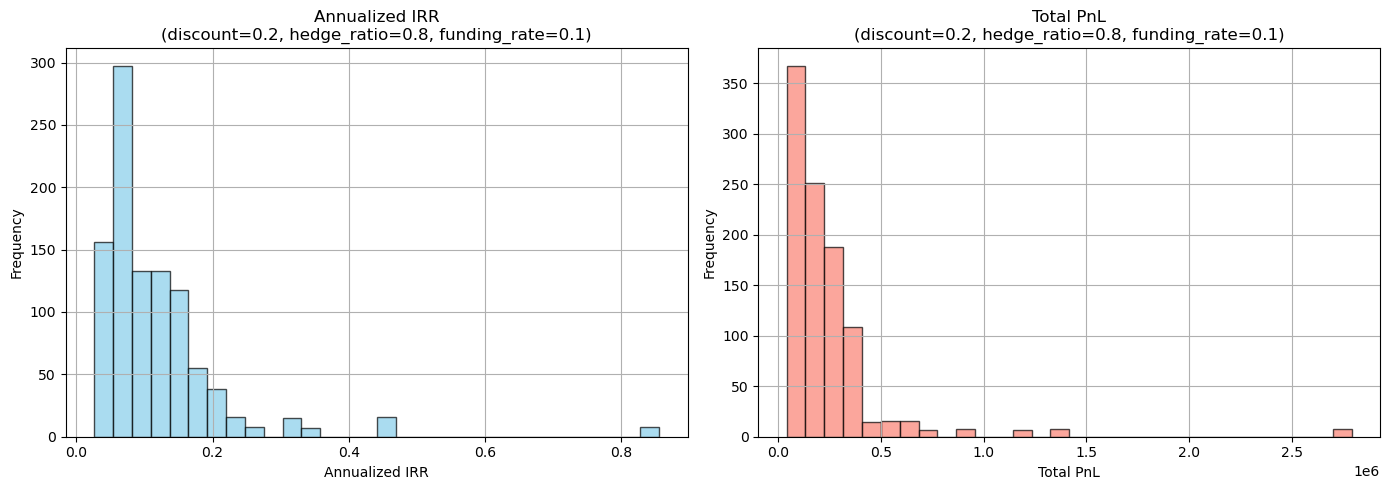

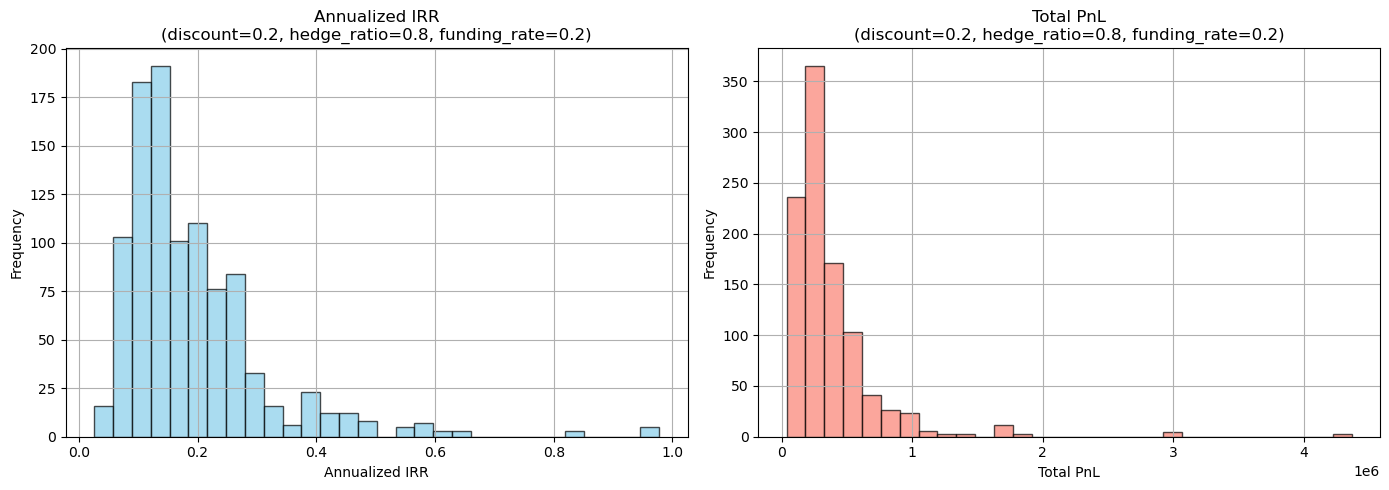

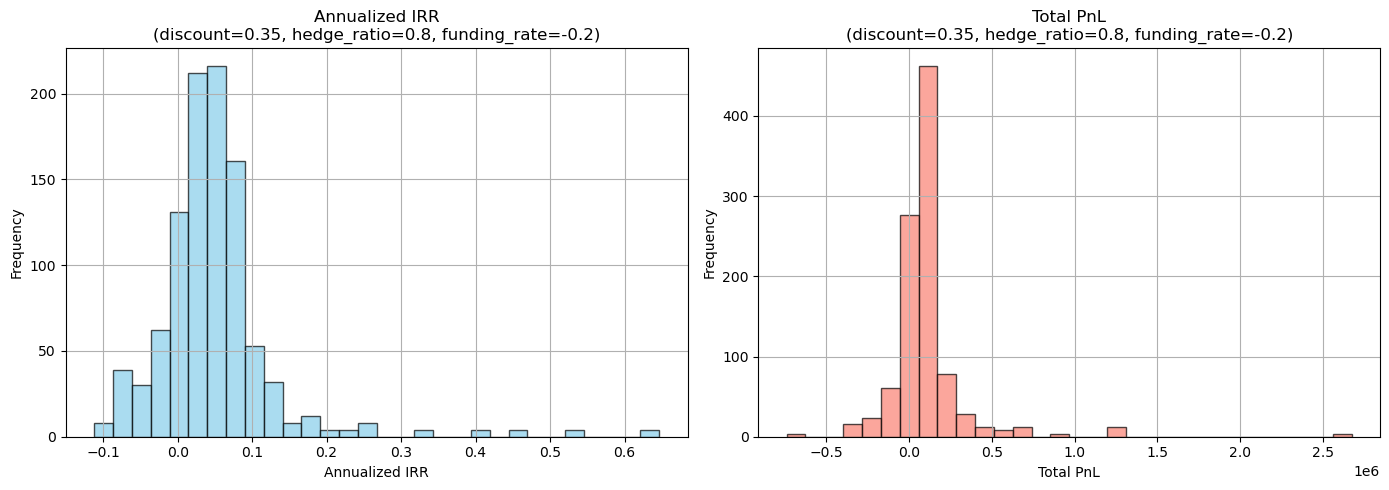

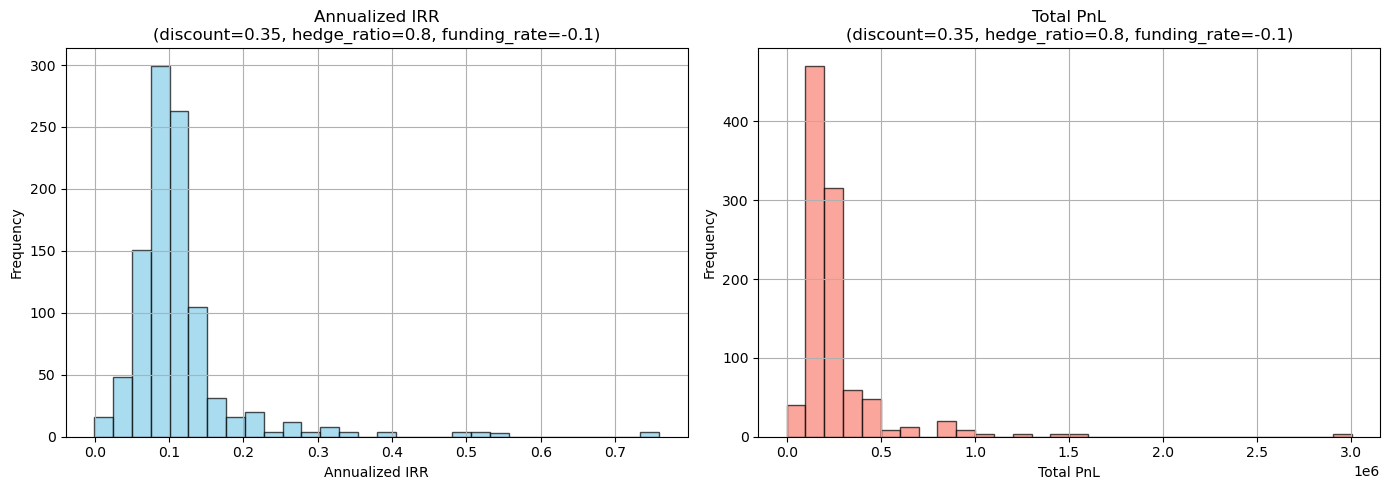

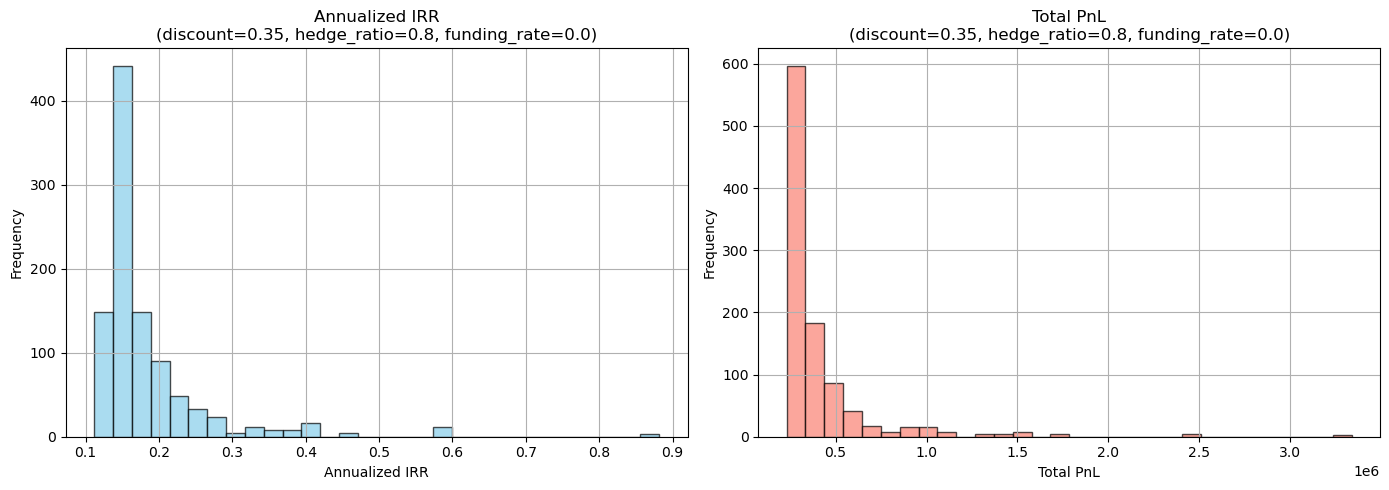

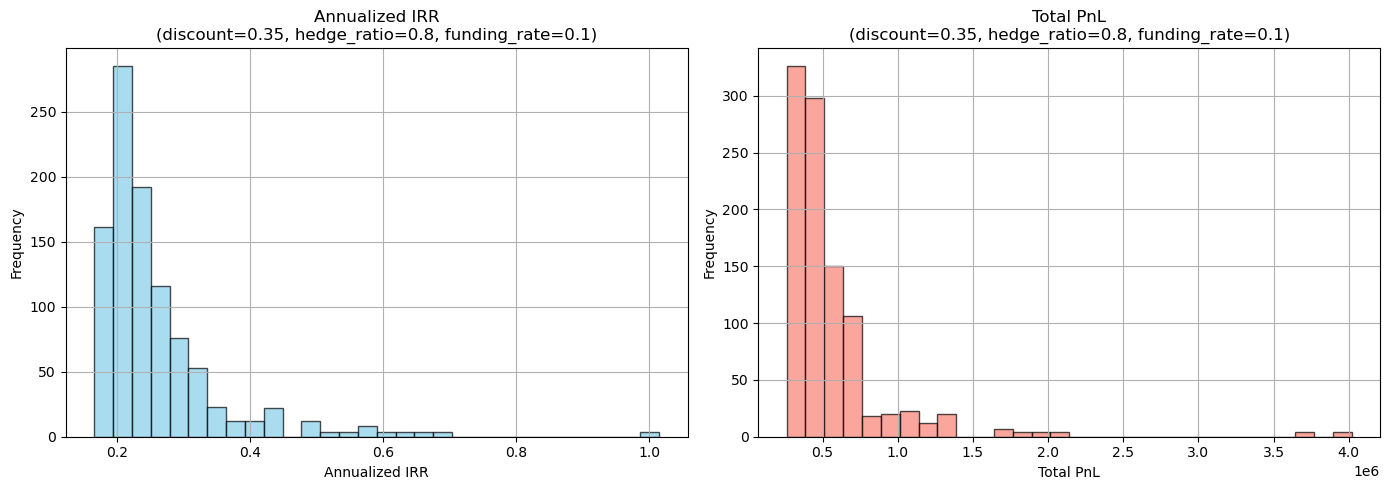

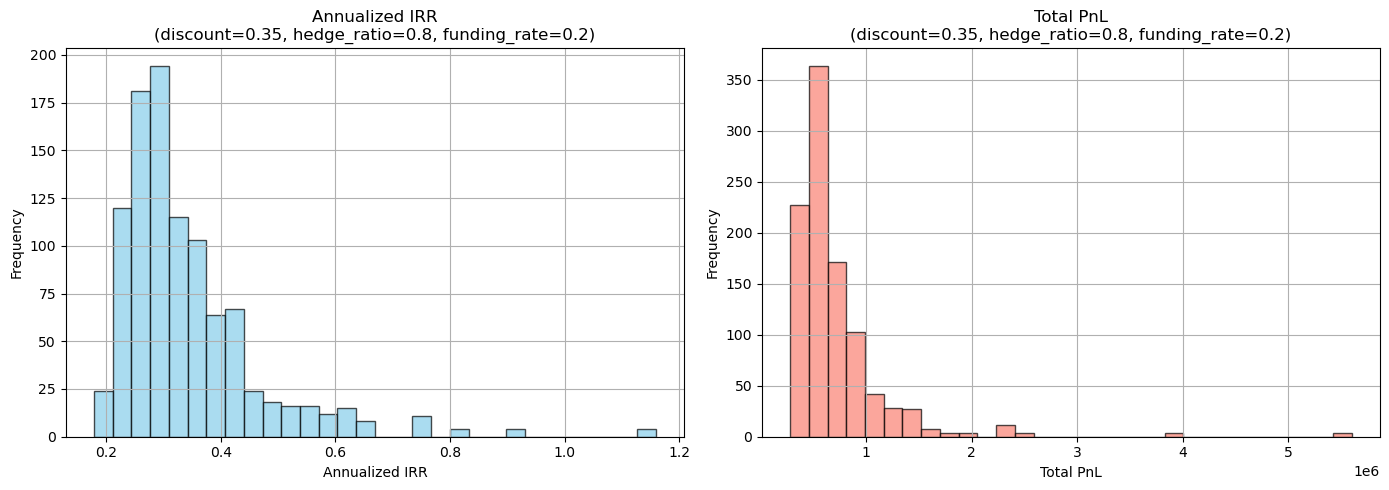

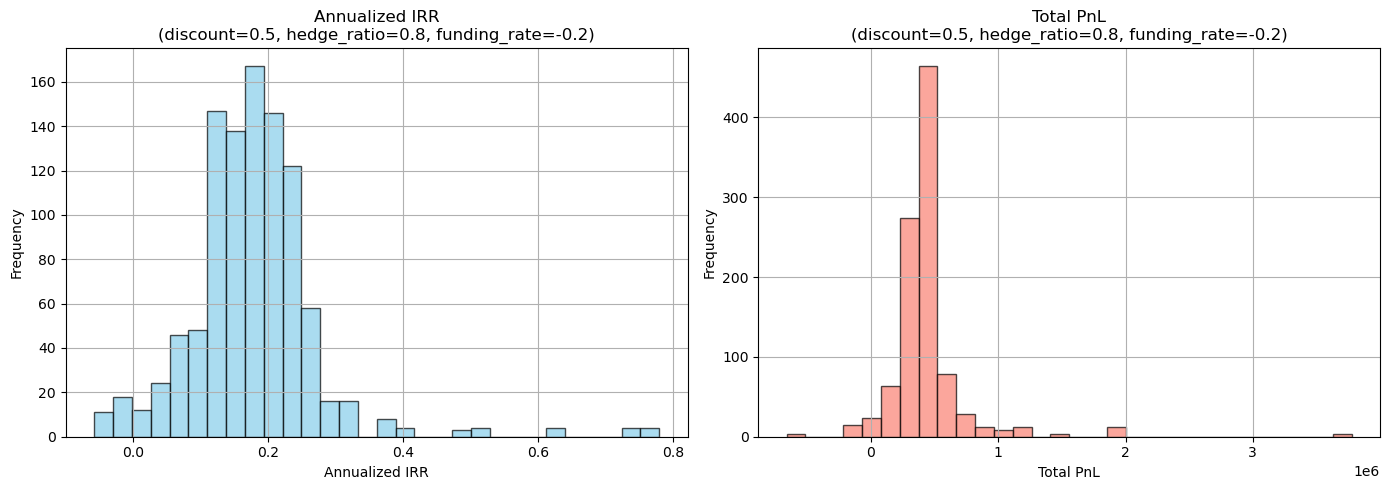

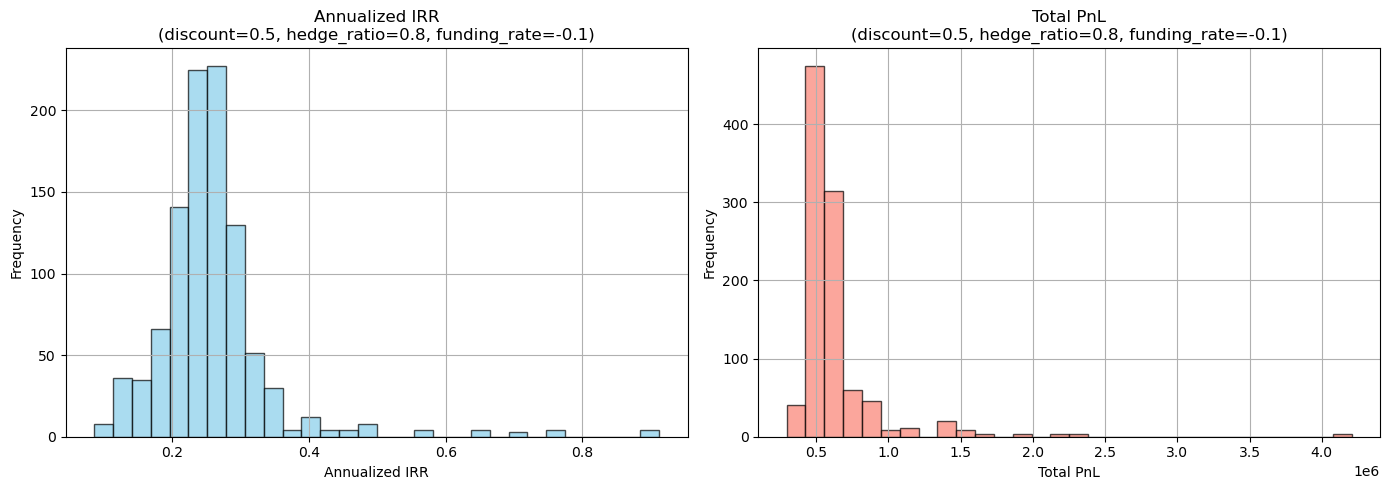

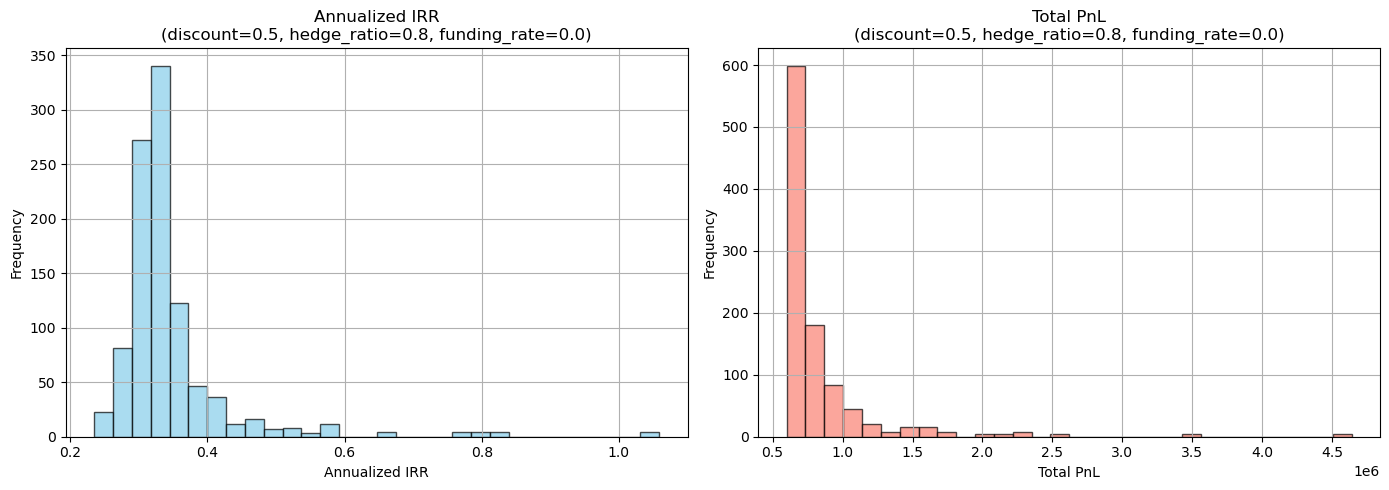

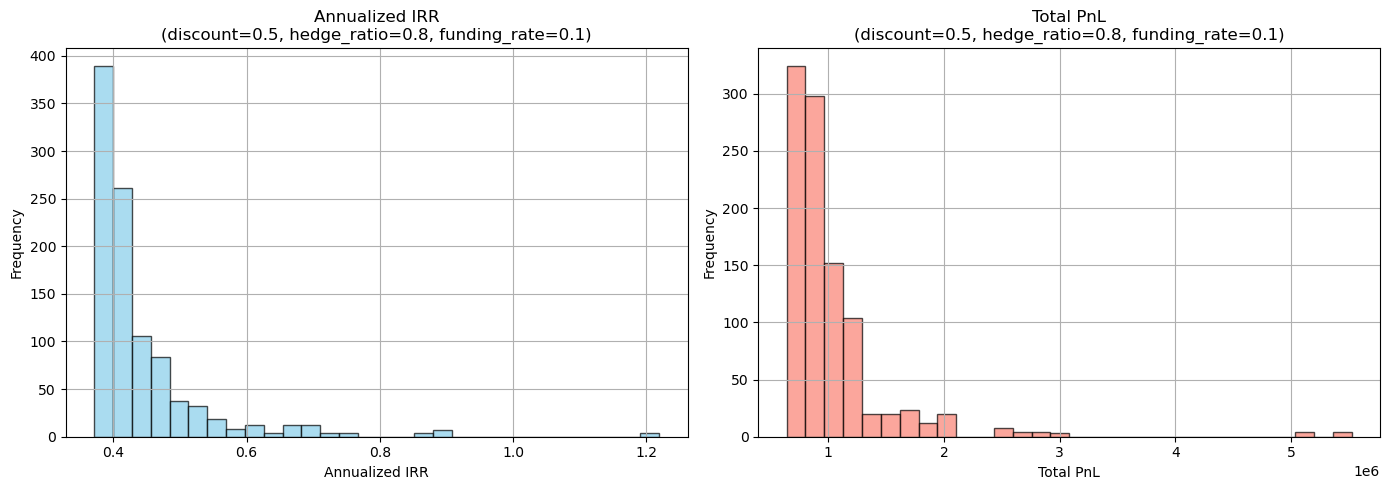

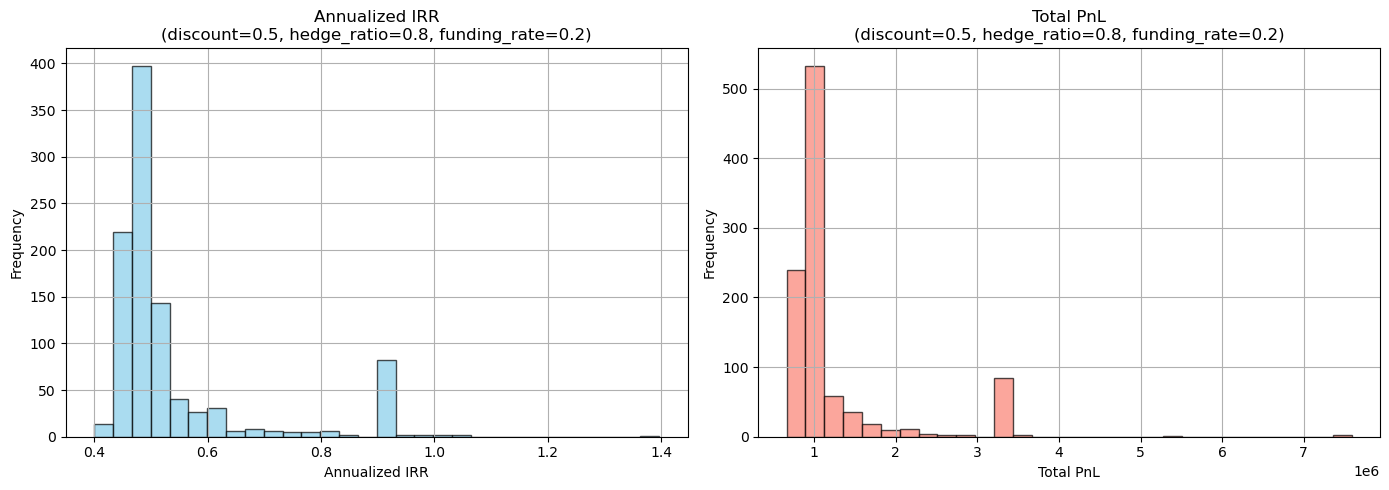

In [42]:
import matplotlib.pyplot as plt

# Loop through each parameter combination key.
for key in sorted(detailed_ann_irr.keys()):
    disc, hedg, fund = key
    ann_irr_values = detailed_ann_irr[key]
    pnl_values = detailed_pnl[key]
    
    # Create a figure with two subplots: one for Annualized IRR and one for Total PnL.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot histogram for Annualized IRR.
    ax1.hist(ann_irr_values, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_xlabel("Annualized IRR")
    ax1.set_ylabel("Frequency")
    ax1.set_title(f"Annualized IRR\n(discount={disc}, hedge_ratio={hedg}, funding_rate={fund})")
    ax1.grid(True)
    
    # Plot histogram for Total PnL.
    ax2.hist(pnl_values, bins=30, alpha=0.7, color='salmon', edgecolor='black')
    ax2.set_xlabel("Total PnL")
    ax2.set_ylabel("Frequency")
    ax2.set_title(f"Total PnL\n(discount={disc}, hedge_ratio={hedg}, funding_rate={fund})")
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()


In [68]:
import numpy as np
import pandas as pd
from scipy.stats import t as student_t

try:
    import numpy_financial as npf
except ImportError:
    npf = None

###############################################################################
# 1) MANUAL TIER DATA (example) - fill in the rest from your screenshot
###############################################################################
manual_eosusdt_tiers = [
    {"notionalFloor": 0,         "notionalCap": 10_000,    "maintMarginRate": 0.0050, "maintAmount": 0},
    {"notionalFloor": 10_000,      "notionalCap": 50_000,    "maintMarginRate": 0.0100, "maintAmount": 50},
    {"notionalFloor": 50_000,      "notionalCap": 80_000,    "maintMarginRate": 0.0150, "maintAmount": 300},
    {"notionalFloor": 80_000,      "notionalCap": 250_000,   "maintMarginRate": 0.0200, "maintAmount": 700},
    {"notionalFloor": 250_000,     "notionalCap": 500_000,   "maintMarginRate": 0.0250, "maintAmount": 1950},
    {"notionalFloor": 500_000,     "notionalCap": 2_000_000, "maintMarginRate": 0.0500, "maintAmount": 14450},
    {"notionalFloor": 2_000_000,   "notionalCap": 3_000_000, "maintMarginRate": 0.1000, "maintAmount": 114450},
    {"notionalFloor": 3_000_000,   "notionalCap": 4_000_000, "maintMarginRate": 0.1250, "maintAmount": 189450},
    {"notionalFloor": 4_000_000,   "notionalCap": 5_000_000, "maintMarginRate": 0.2500, "maintAmount": 689450},
    {"notionalFloor": 5_000_000,   "notionalCap": 6_000_000, "maintMarginRate": 0.5000, "maintAmount": 1939450},
]


###############################################################################
# 2) HELPER FUNCTION: GET REQUIRED MARGIN
###############################################################################
def get_required_margin(notional, maint_data):
    """
    Given a notional and a list of maintenance margin tiers (maint_data), 
    return the required margin using:
    
        required_margin = max(notional * maintMarginRate - maintAmount, 0)
    
    for the tier in which notional <= notionalCap.
    If notional exceeds all tiers, use the last tier.
    """
    for tier in maint_data:
        if notional <= tier['notionalCap']:
            return max(notional * tier['maintMarginRate'] - tier['maintAmount'], 0.0)
    # If notional exceeds all tiers, use the last tier
    tier = maint_data[-1]
    return max(notional * tier['maintMarginRate'] - tier['maintAmount'], 0.0)

###############################################################################
# 3) MAIN SIMULATION FUNCTION
###############################################################################
def simulate_strategy(
    P0, investment_amount, discount, hedge_ratio, T, annual_vol, annual_funding_rate,
    cliff_months=0, price_floor=None, seed=None, external_shocks=None, maint_margin_data=None
):
    if seed is not None:
        np.random.seed(seed)

    Q = investment_amount / (P0 * (1 - discount))

    # === Price Simulation Setup ===
    price_outlook = "bearish"
    outlook_drifts = {"bearish": -0.10, "neutral": 0.00, "bullish": 0.10}
    mu = np.log(1 + outlook_drifts.get(price_outlook, 0.0))
    dt = 1 / 12.0
    prices = [P0]

    # Fat-tailed shocks: if external shocks provided, use them; else generate new.
    df_t = 3.0
    skew_strength = 0.0
    if external_shocks is not None:
        shocks = external_shocks
    else:
        shocks = student_t.rvs(df_t, size=T)
        shocks /= np.sqrt(df_t / (df_t - 2))
        shocks = np.where(shocks >= 0, shocks * (1 + skew_strength), shocks * (1 - skew_strength))
    
    for Z in shocks:
        last_price = prices[-1]
        Pt = last_price * np.exp((mu - 0.5 * annual_vol**2)*dt + annual_vol * np.sqrt(dt)*Z)
        prices.append(max(Pt, price_floor) if price_floor is not None else Pt)

    # === Initialize Strategy Variables ===
    details = []
    collateral_series = []

    token_cost = Q * P0 * (1 - discount)
    hedged_tokens = hedge_ratio * Q
    unhedged_tokens = Q - hedged_tokens
    
    # Calculate initial required collateral
    if maint_margin_data is not None:
        initial_required = get_required_margin(hedged_tokens * P0, maint_margin_data)
        initial_collateral = initial_required
    else:
        initial_collateral = (1/3) * (hedged_tokens * P0)
    
    cf0 = -token_cost - initial_collateral

    details.append({
        "time": 0.0, "month": 0, "price": P0,
        "remaining_long": Q, "remaining_short": hedged_tokens,
        "collateral": initial_collateral, "collateral_flow": -initial_collateral,
        "funding_cash_flow": 0.0, "hedged_sale_flow": 0.0, "hedged_cover_flow": 0.0,
        "unhedged_sale_flow": 0.0, "vesting_total_flow": 0.0,
        "total_cf": cf0, "note": "Initial Setup"
    })

    remaining_long = Q
    remaining_short = hedged_tokens
    collateral = initial_collateral
    total_funding_cost = 0.0
    vest_months = max(T - cliff_months, 1)
    vest_per_month = Q / vest_months

    monthly_cash_flows = []

    # === Monthly Simulation Loop ===
    for t in range(1, T + 1):
        time_year = t / 12.0
        price_prev = prices[t - 1]
        current_price = prices[t]

        # 1) Calculate new required collateral
        notional = remaining_short * price_prev
        if maint_margin_data is not None:
            new_collateral_required = get_required_margin(notional, maint_margin_data)


        collateral_change = new_collateral_required - collateral
        collateral_flow = -collateral_change
        collateral = new_collateral_required
        collateral_series.append(collateral)

        # 2) Funding Cost
        funding_cost = (annual_funding_rate / 12.0) * notional
        total_funding_cost += funding_cost

        # 3) Vesting
        if t > cliff_months:
            vested = vest_per_month
        else:
            vested = 0.0

        tokens_hedged_vesting = min(vested, remaining_short)
        hedged_sale_flow = tokens_hedged_vesting * current_price
        hedged_cover_flow = tokens_hedged_vesting * (P0 - current_price)
        net_hedged = hedged_sale_flow + hedged_cover_flow  # always tokens_hedged_vesting * P0

        tokens_unhedged = vested - tokens_hedged_vesting
        unhedged_sale_flow = tokens_unhedged * current_price

        vesting_total_flow = net_hedged + unhedged_sale_flow

        remaining_short -= tokens_hedged_vesting
        remaining_long -= vested

        total_cf_month = collateral_flow + funding_cost + vesting_total_flow

        details.append({
            "time": time_year, "month": t, "price": current_price,
            "remaining_long": remaining_long, "remaining_short": remaining_short,
            "collateral": collateral, "collateral_flow": collateral_flow,
            "funding_cash_flow": funding_cost,
            "hedged_sale_flow": hedged_sale_flow,
            "hedged_cover_flow": hedged_cover_flow,
            "unhedged_sale_flow": unhedged_sale_flow,
            "vesting_total_flow": vesting_total_flow,
            "total_cf": total_cf_month,
            "note": f"Month {t} vesting: hedged {tokens_hedged_vesting:.2f}, unhedged {tokens_unhedged:.2f}"
        })

        monthly_cash_flows.append((time_year, total_cf_month))

    # === Final Settlement ===
    final_time = T / 12.0
    final_price = prices[-1]
    final_sale = remaining_long * final_price
    final_short_settlement = remaining_short * (P0 - final_price) if remaining_short > 0 else 0.0
    collateral_release = collateral
    final_total_cf = final_sale + final_short_settlement + collateral_release

    details.append({
        "time": final_time, "month": T,
        "price": final_price,
        "remaining_long": 0.0,
        "remaining_short": 0.0,
        "collateral": 0.0,
        "collateral_flow": collateral_release,
        "funding_cash_flow": 0.0,
        "hedged_sale_flow": 0.0,
        "hedged_cover_flow": final_short_settlement,
        "unhedged_sale_flow": final_sale,
        "vesting_total_flow": final_sale + final_short_settlement,
        "total_cf": final_total_cf,
        "note": "Final Settlement"
    })

    # Build final results
    cash_flows = [(row["time"], row["total_cf"]) for row in details]
    values_arr = np.array([cf for _, cf in cash_flows])
    irr = npf.irr(values_arr) if npf else None
    monthly_irr = irr
    annual_irr = (1 + monthly_irr)**12 - 1 if monthly_irr is not None else None
    total_pnl = np.sum(values_arr)
    df_details = pd.DataFrame(details)

    return {
        "prices": prices,
        "collateral_series": collateral_series,
        "cash_flows": cash_flows,
        "IRR": irr,
        "Total_PnL": total_pnl,
        "Total_Funding_Cost": total_funding_cost,
        "simulation_details": df_details,
        "Annualized IRR": annual_irr
    }

###############################################################################
# 4) EXAMPLE USAGE
###############################################################################
if __name__ == "__main__":
    # Example: run the simulation using the manually defined tiers for EOSUSDT.
    results = simulate_strategy(
        P0=0.7870,                      # initial token price
        investment_amount=1_000_000,    # total cash to invest
        discount=0.40,                  # discount
        hedge_ratio=1,                  # fully hedged
        T=24,                           # 24 months vesting
        annual_vol=1.01,                # 101% annual volatility
        annual_funding_rate=0.05,       # 5% annual funding
        cliff_months=12,                # vesting starts after 12 months
        seed=42,                        # reproducibility
        maint_margin_data=manual_eosusdt_tiers  # use the manual tiers
    )

    print("=== Simulation Results ===")
    print("Annualized IRR:", results["Annualized IRR"])
    print("Total PnL:", results["Total_PnL"])
    print("\n--- Monthly Simulation Details ---")
    print(results["simulation_details"])
    print("\n--- Price Path ---")
    print(results["prices"])
    print("\n--- Cash Flows (time in years, cash) ---")
    for t, cf in results["cash_flows"]:
        print(f"t = {t:.2f} years: {cf:.2f}")


=== Simulation Results ===
Annualized IRR: 0.44485685858985
Total PnL: 757597.333922948

--- Monthly Simulation Details ---
        time  month     price  remaining_long  remaining_short     collateral  \
0   0.000000      0  0.787000    2.117747e+06     2.117747e+06   68883.333333   
1   0.083333      1  0.827295    2.117747e+06     2.117747e+06   68883.333333   
2   0.166667      2  0.653619    2.117747e+06     2.117747e+06   73150.086859   
3   0.250000      3  0.773076    2.117747e+06     2.117747e+06   54759.953245   
4   0.333333      4  0.635583    2.117747e+06     2.117747e+06   67408.911149   
5   0.416667      5  0.720157    2.117747e+06     2.117747e+06   52850.219174   
6   0.500000      6  1.024937    2.117747e+06     2.117747e+06   61805.505454   
7   0.583333      7  0.646830    2.117747e+06     2.117747e+06  102605.681911   
8   0.666667      8  0.559808    2.117747e+06     2.117747e+06   54041.069446   
9   0.750000      9  0.481795    2.117747e+06     2.117747e+06   4